# General setup

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, classification_report)
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

# My three classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# For reproducibility
RANDOM_SEED = 42

Create functions

In [3]:
def get_classifiers():
    """Return dictionary of classifiers with initial parameters"""
    classifiers = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,  # Start with 100 trees
            random_state=RANDOM_SEED,
            n_jobs=-1  # Use all CPU cores
        ),
        
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(100,),  # Start with one hidden layer
            max_iter=1000,
            random_state=RANDOM_SEED
        ),
        
        'SVM': SVC(
            kernel='rbf',
            probability=True,  # Needed for ROC curves
            random_state=RANDOM_SEED
        )
    }
    return classifiers

# Function to create different train-test splits
def create_splits(X, y):
    """Create different train-test splits (20-80, 50-50, 80-20)"""
    splits = {}
    
    # 20-80 split
    X_train_20, X_test_80, y_train_20, y_test_80 = train_test_split(
        X, y, train_size=0.2, random_state=RANDOM_SEED)
    splits['20-80'] = (X_train_20, X_test_80, y_train_20, y_test_80)
    
    # 50-50 split
    X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(
        X, y, train_size=0.5, random_state=RANDOM_SEED)
    splits['50-50'] = (X_train_50, X_test_50, y_train_50, y_test_50)
    
    # 80-20 split
    X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(
        X, y, train_size=0.8, random_state=RANDOM_SEED)
    splits['80-20'] = (X_train_80, X_test_20, y_train_80, y_test_20)
    
    return splits

In [4]:
# Define parameter grids for cross-validation
def get_param_grids():
    """Define simplified parameter grids with focus on preventing overfitting"""
    param_grids = {
        'Random Forest': {
            'n_estimators': [100],  # Simplified to single value
            'max_depth': [3, 5, 10],  # Added smaller depths
            'min_samples_split': [5, 10],  # Increased to prevent too-small splits
            'max_features': ['sqrt']  # Add feature selection
        },
        'Neural Network': {
            'hidden_layer_sizes': [(10,), (20,)],  # Smaller networks
            'alpha': [0.01, 0.1],  # Stronger regularization
            'learning_rate_init': [0.01],
            'early_stopping': [True],
            'validation_fraction': [0.2]
        },
        'SVM': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf']  # Simplified to just RBF kernel
        }
    }
    return param_grids

# def get_param_grids():
#     """Define parameter grids for each classifier"""
#     param_grids = {
#         'Random Forest': {
#             'n_estimators': [100, 200],
#             'max_depth': [None, 10, 20],
#             'min_samples_split': [2, 5]
#         },
#         'Neural Network': {
#             'hidden_layer_sizes': [(50,), (100,), (50, 50)],
#             'alpha': [0.0001, 0.001],
#             'learning_rate_init': [0.001, 0.01]
#         },
#         'SVM': {
#             'C': [0.1, 1, 10],
#             'gamma': ['scale', 'auto', 0.1],
#             'kernel': ['rbf', 'linear']
#         }
#     }
#     return param_grids

In [5]:
# def run_experiment_with_cv(X, y, trial_num):
#     """Run experiment with cross-validation for hyperparameter tuning"""
#     results = []
#     param_grids = get_param_grids()
#     splits = create_splits(X, y)
#     base_classifiers = get_classifiers()
    
#     for split_name, (X_train, X_test, y_train, y_test) in splits.items():
#         # Scale the features
#         scaler = StandardScaler()
#         X_train_scaled = scaler.fit_transform(X_train)
#         X_test_scaled = scaler.transform(X_test)
        
#         for clf_name, base_clf in tqdm(base_classifiers.items(), 
#                                      desc=f'Trial {trial_num+1}, Split {split_name}'):
#             # Perform GridSearchCV
#             grid_search = GridSearchCV(
#                 estimator=base_clf,
#                 param_grid=param_grids[clf_name],
#                 cv=5,
#                 scoring='roc_auc',
#                 n_jobs=-1
#             )
            
#             # Fit and get best model
#             grid_search.fit(X_train_scaled, y_train)
#             best_clf = grid_search.best_estimator_
            
#             # Make predictions
#             y_pred = best_clf.predict(X_test_scaled)
            
#             # Calculate metrics
#             accuracy = accuracy_score(y_test, y_pred)
#             roc_auc = roc_auc_score(y_test, best_clf.predict_proba(X_test_scaled)[:,1])
            
#             # Store results
#             results.append({
#                 'trial': trial_num,
#                 'split': split_name,
#                 'classifier': clf_name,
#                 'accuracy': accuracy,
#                 'roc_auc': roc_auc,
#                 'best_params': str(grid_search.best_params_)
#             })
    
#     return pd.DataFrame(results)

# # works, but line graphs
# def plot_classifier_results(grid_searches, split_name):
#     """
#     Create a single figure with subplots for all classifier results
    
#     Parameters:
#     grid_searches: dict - Dictionary with classifier names as keys and their GridSearchCV results as values
#     split_name: str - Name of the current train-test split
#     """
#     # Create a figure with subplots
#     fig, axes = plt.subplots(len(grid_searches), 2, figsize=(15, 5*len(grid_searches)))
#     fig.suptitle(f'Classifier Performance Analysis - {split_name} Split', fontsize=16)
    
#     for idx, (clf_name, grid_search) in enumerate(grid_searches.items()):
#         # Get cross validation results
#         results = pd.DataFrame(grid_search.cv_results_)
        
#         # Learning curve (left subplot)
#         axes[idx, 0].plot(results.mean_train_score, 'o-', label='Training score')
#         axes[idx, 0].plot(results.mean_test_score, 'o-', label='Cross-validation score')
#         axes[idx, 0].set_title(f'{clf_name} Learning Curves')
#         axes[idx, 0].set_xlabel('Parameter Combination Index')
#         axes[idx, 0].set_ylabel('Score')
#         axes[idx, 0].legend()
#         axes[idx, 0].grid(True)
        
#         # Parameter scores (right subplot)
#         param_scores = results.pivot_table(
#             values='mean_test_score',
#             index=results.columns[results.columns.str.startswith('param_')].tolist(),
#             aggfunc='mean'
#         ).round(3)
        
#         # Display as text instead of heatmap
#         axes[idx, 1].axis('off')
#         axes[idx, 1].text(0, 0.5, 
#                          f"Best Parameters:\n{grid_search.best_params_}\n\n"
#                          f"Best Score: {grid_search.best_score_:.3f}\n\n"
#                          f"All Parameter Combinations:\n{param_scores.to_string()}",
#                          fontfamily='monospace',
#                          verticalalignment='center')
#         axes[idx, 1].set_title(f'{clf_name} Parameter Analysis')
    
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.95)
#     plt.show()

def plot_classifier_results(grid_searches, split_name):
    """
    Create visualizations with parameter details, performance plots, and heatmaps
    """
    for clf_name, grid_search in grid_searches.items():
        # Get cross validation results
        results = pd.DataFrame(grid_search.cv_results_)
        param_cols = [col for col in results.columns if col.startswith('param_')]
        
        # Create figure with gridspec for flexible subplot layout
        if len(param_cols) >= 2:  # If we can make a heatmap
            fig = plt.figure(figsize=(15, 12))
            gs = plt.GridSpec(3, 2, height_ratios=[2, 2, 1])
        else:
            fig = plt.figure(figsize=(15, 10))
            gs = plt.GridSpec(2, 2, height_ratios=[2, 1])
        
        # 1. Performance Scatter Plot (top left)
        ax1 = fig.add_subplot(gs[0, 0])
        scatter = ax1.scatter(range(len(results)), results.mean_test_score, 
                            label='Cross-validation score', alpha=0.7)
        ax1.scatter(range(len(results)), results.mean_train_score, 
                   label='Training score', alpha=0.7)
        ax1.set_title(f'{clf_name} Performance by Configuration')
        ax1.set_xlabel('Configuration Index')
        ax1.set_ylabel('Score')
        ax1.legend()
        ax1.grid(True)
        
        # 2. Parameter Details Table (top right)
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.axis('off')
        
        # Create parameter details table
        param_data = results[param_cols + ['mean_test_score', 'mean_train_score']].round(3)
        param_data = param_data.rename(columns={
            col: col.replace('param_', '') for col in param_cols
        })
        
        table_data = [[f"Config {i}"] + row.tolist() 
                     for i, row in param_data.iterrows()]
        column_labels = ['Config'] + param_data.columns.tolist()
        
        table = ax2.table(cellText=table_data,
                         colLabels=column_labels,
                         loc='center',
                         cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        
        # 3. Heatmap (middle row) if we have enough parameters
        if len(param_cols) >= 2:
            ax3 = fig.add_subplot(gs[1, :])
            param1 = param_cols[0].replace('param_', '')
            param2 = param_cols[1].replace('param_', '')
            
            heatmap_data = results.pivot_table(
                values='mean_test_score',
                index=param_cols[0],
                columns=param_cols[1],
                aggfunc='mean'
            )
            
            sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', ax=ax3)
            ax3.set_title(f'{clf_name} Parameter Interaction\n{param1} vs {param2}')
            
            # Best Parameters (bottom)
            ax4 = fig.add_subplot(gs[2, :])
            ax4.axis('off')
            best_params_text = (f"Best Parameters:\n{grid_search.best_params_}\n\n"
                              f"Best Score: {grid_search.best_score_:.3f}")
            ax4.text(0.5, 0.5, best_params_text,
                    ha='center', va='center',
                    fontfamily='monospace',
                    bbox=dict(facecolor='white', alpha=0.8))
        else:
            # Best Parameters (bottom) when no heatmap
            ax3 = fig.add_subplot(gs[1, :])
            ax3.axis('off')
            best_params_text = (f"Best Parameters:\n{grid_search.best_params_}\n\n"
                              f"Best Score: {grid_search.best_score_:.3f}")
            ax3.text(0.5, 0.5, best_params_text,
                    ha='center', va='center',
                    fontfamily='monospace',
                    bbox=dict(facecolor='white', alpha=0.8))
        
        plt.suptitle(f'Classifier Performance Analysis - {split_name} Split\n{clf_name}',
                    fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

def run_experiment_with_cv(X, y, trial_num):
    """Run experiment with cross-validation and visualization"""
    results = []
    param_grids = get_param_grids()
    splits = create_splits(X, y)
    base_classifiers = get_classifiers()
    
    for split_name, (X_train, X_test, y_train, y_test) in splits.items():
        print(f"\nProcessing split: {split_name}")
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Store grid search results for visualization
        split_grid_searches = {}
        
        for clf_name, base_clf in tqdm(base_classifiers.items(), 
                                     desc=f'Trial {trial_num+1}, Split {split_name}'):
            # Perform GridSearchCV
            grid_search = GridSearchCV(
                estimator=base_clf,
                param_grid=param_grids[clf_name],
                cv=5,
                scoring='roc_auc',
                n_jobs=-1,
                return_train_score=True
            )
            
            # Fit and get best model
            grid_search.fit(X_train_scaled, y_train)
            best_clf = grid_search.best_estimator_
            
            # Store grid search results
            split_grid_searches[clf_name] = grid_search
            
            # Make predictions
            y_pred = best_clf.predict(X_test_scaled)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, best_clf.predict_proba(X_test_scaled)[:,1])
            
            # Store results
            results.append({
                'trial': trial_num,
                'split': split_name,
                'classifier': clf_name,
                'accuracy': accuracy,
                'roc_auc': roc_auc,
                'best_params': str(grid_search.best_params_)
            })
        
        # Create visualization for this split
        plot_classifier_results(split_grid_searches, split_name)
    
    return pd.DataFrame(results)

In [6]:
def plot_learning_curves(X, y, classifier_name, classifier):
    """Plot learning curves for a classifier"""
    train_sizes = np.linspace(0.1, 1.0, 5)
    
    train_sizes, train_scores, test_scores = learning_curve(
        classifier, X, y,
        train_sizes=train_sizes, cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')
    
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1)
    
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title(f'Learning Curves for {classifier_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Heart Disease dataset

Source: https://archive.ics.uci.edu/dataset/45/heart+disease

### Data setup

In [12]:
# OLD CODE - CAN'T USE DUE TO UCI REPO BEING DOWN
# # Load the heart disease dataset
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
# columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
#            'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
# data = pd.read_csv(url, names=columns, na_values='?')


# work with zip file instead
import zipfile

zip_path = 'heart+disease.zip'

columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

# Read the Cleveland data from the zip file
with zipfile.ZipFile('heart+disease.zip', 'r') as zip_ref:
    with zip_ref.open('processed.cleveland.data') as file:
        data = pd.read_csv(file, names=columns, na_values='?')

In [13]:
# Basic data exploration
print("Dataset Shape:", data.shape)
print("\nFirst few rows:")
print(data.head())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(data.describe())

# Class distribution
print("\nClass distribution:")
print(data['target'].value_counts())

Dataset Shape: (303, 14)

First few rows:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  

Missing values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

Basic statistics:
              age         sex          cp    trestbps        chol     

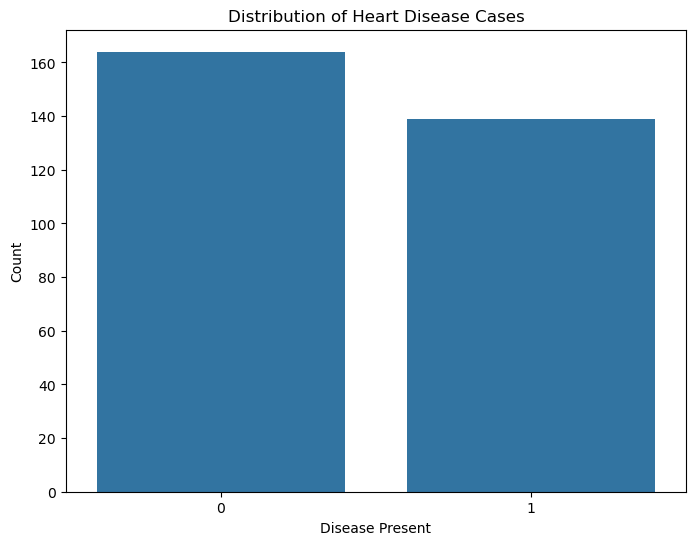

In [14]:
# Convert target to binary (0 for no disease, 1 for disease)
data['target'] = data['target'].map(lambda x: 1 if x > 0 else 0)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='target')
plt.title('Distribution of Heart Disease Cases')
plt.xlabel('Disease Present')
plt.ylabel('Count')
plt.show()

# Split features and target
X = data.drop('target', axis=1)
y = data['target']

# Handle any missing values
if X.isnull().any().any():
    X = X.fillna(X.mean())

### Run experiments

Running experiments with cross-validation...

Processing split: 20-80


Trial 1, Split 20-80: 100%|██████████| 3/3 [00:27<00:00,  9.19s/it]


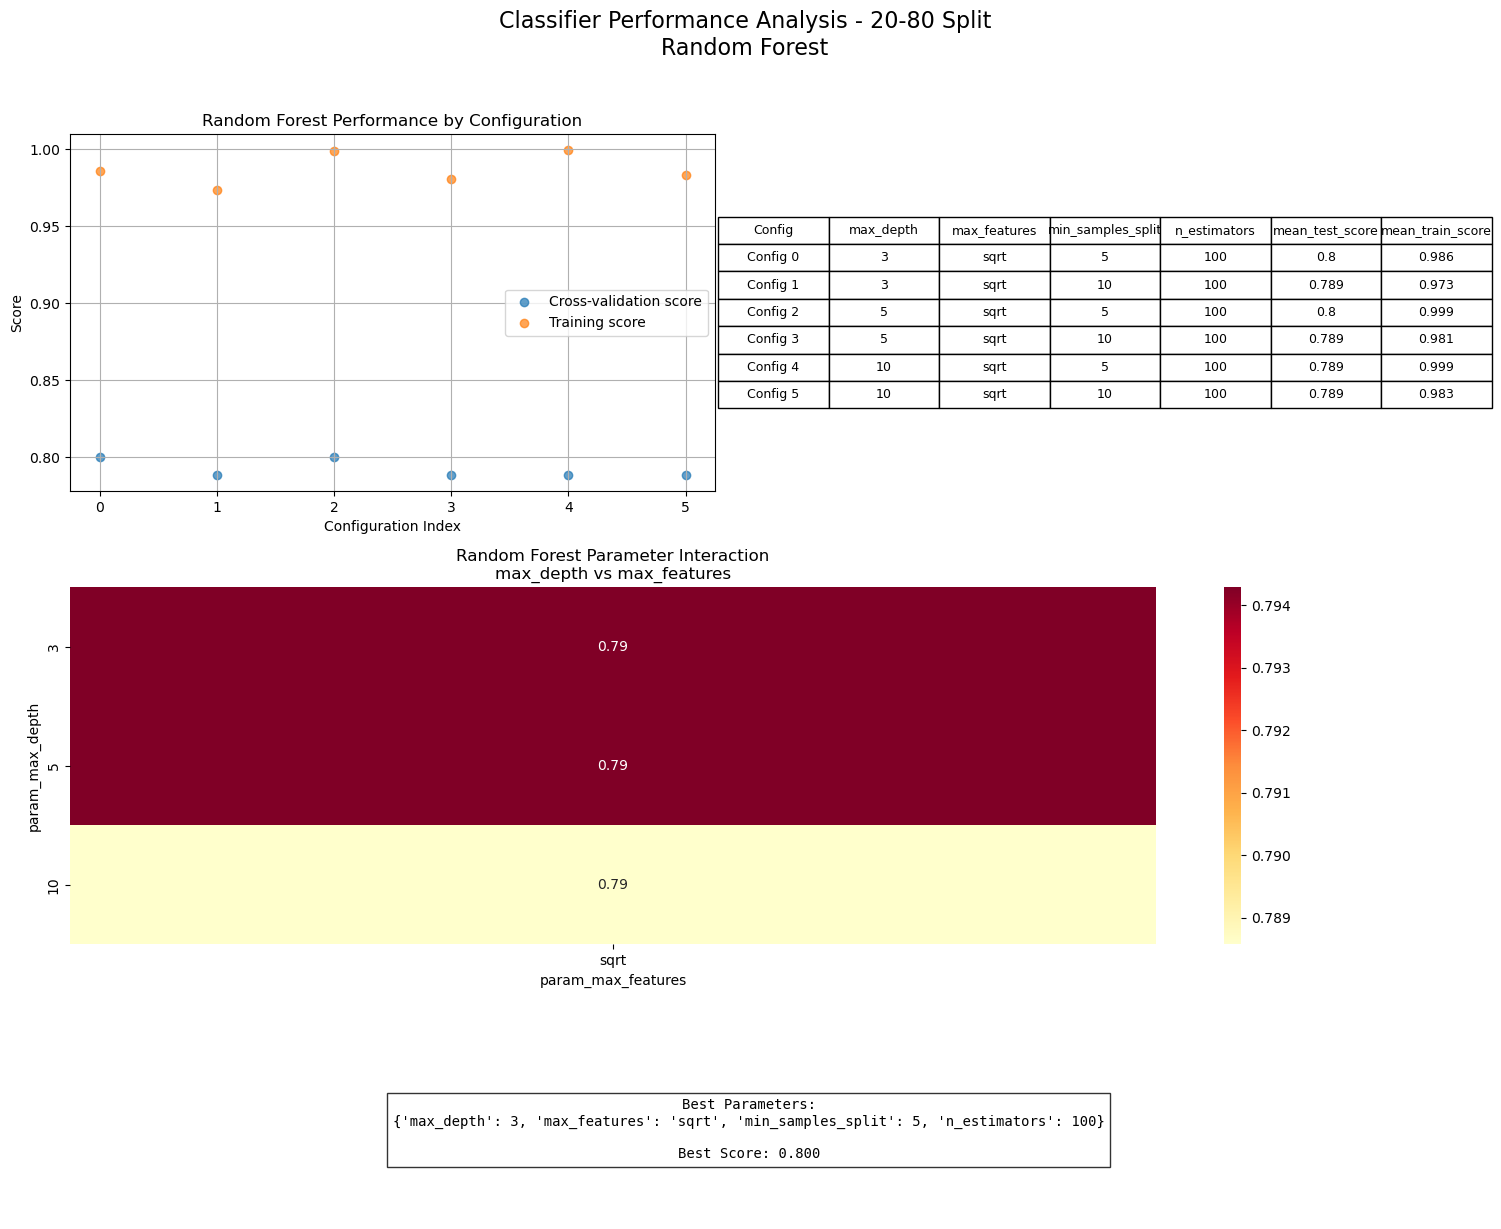

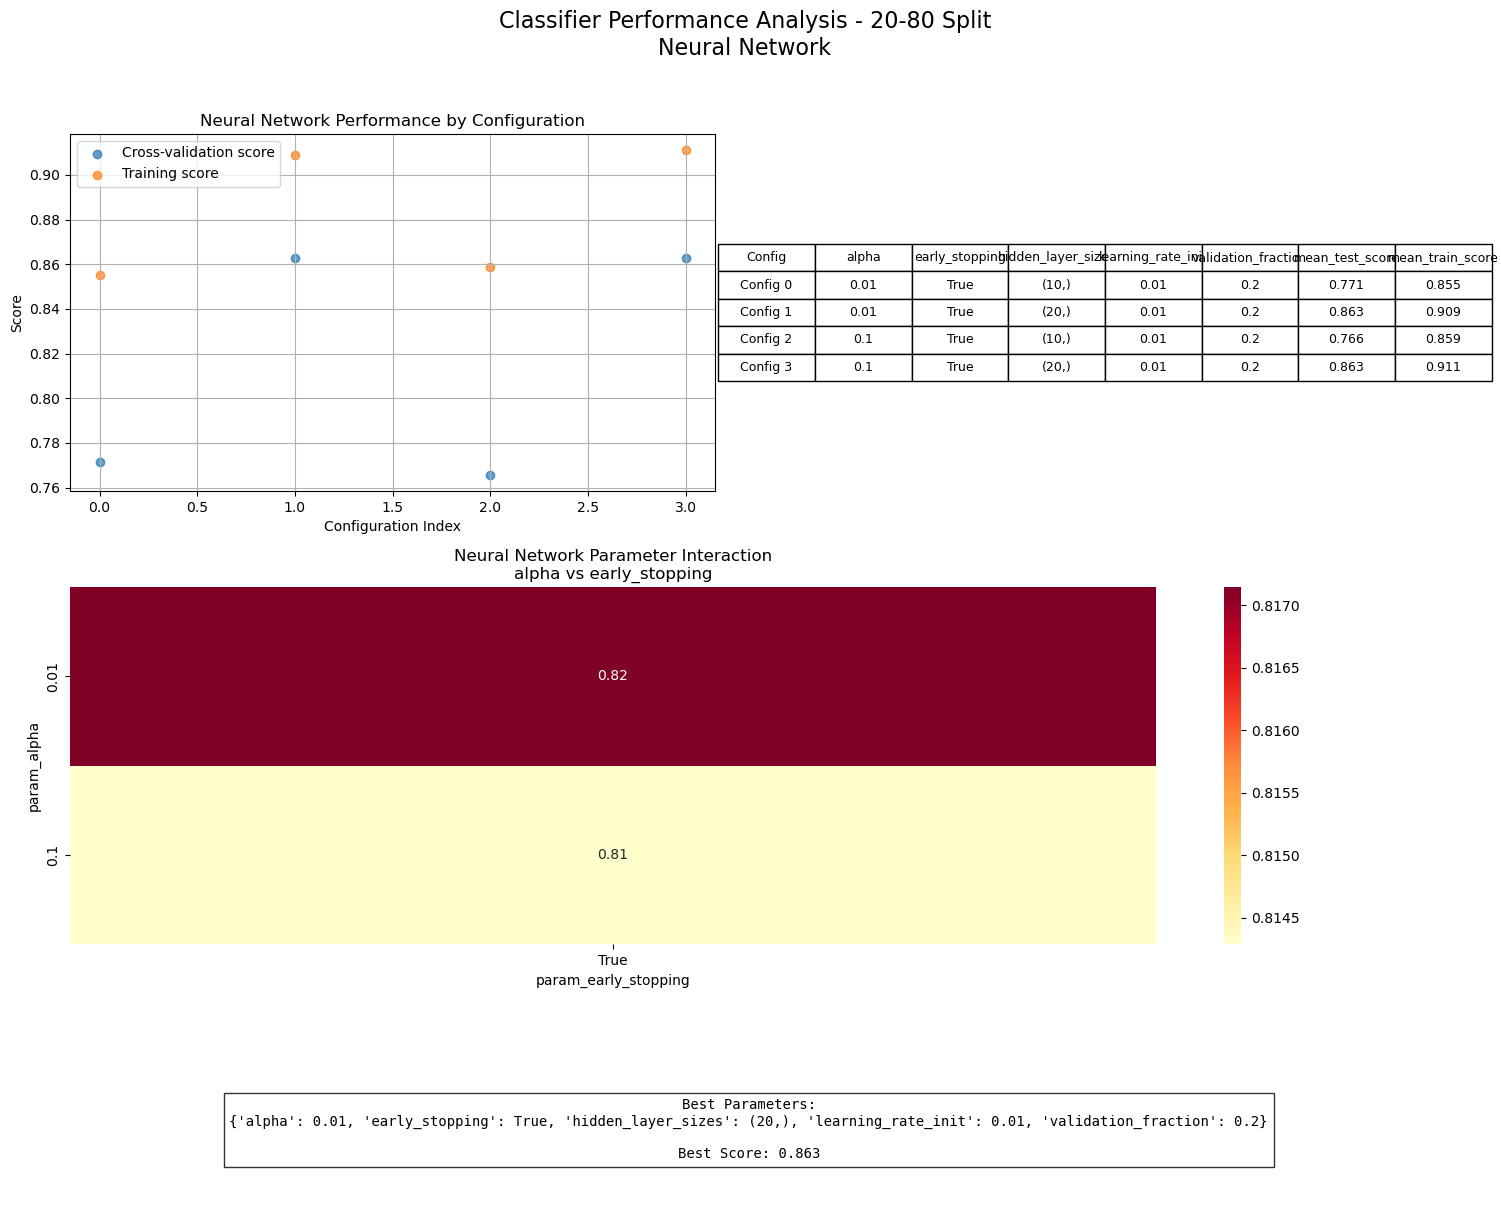

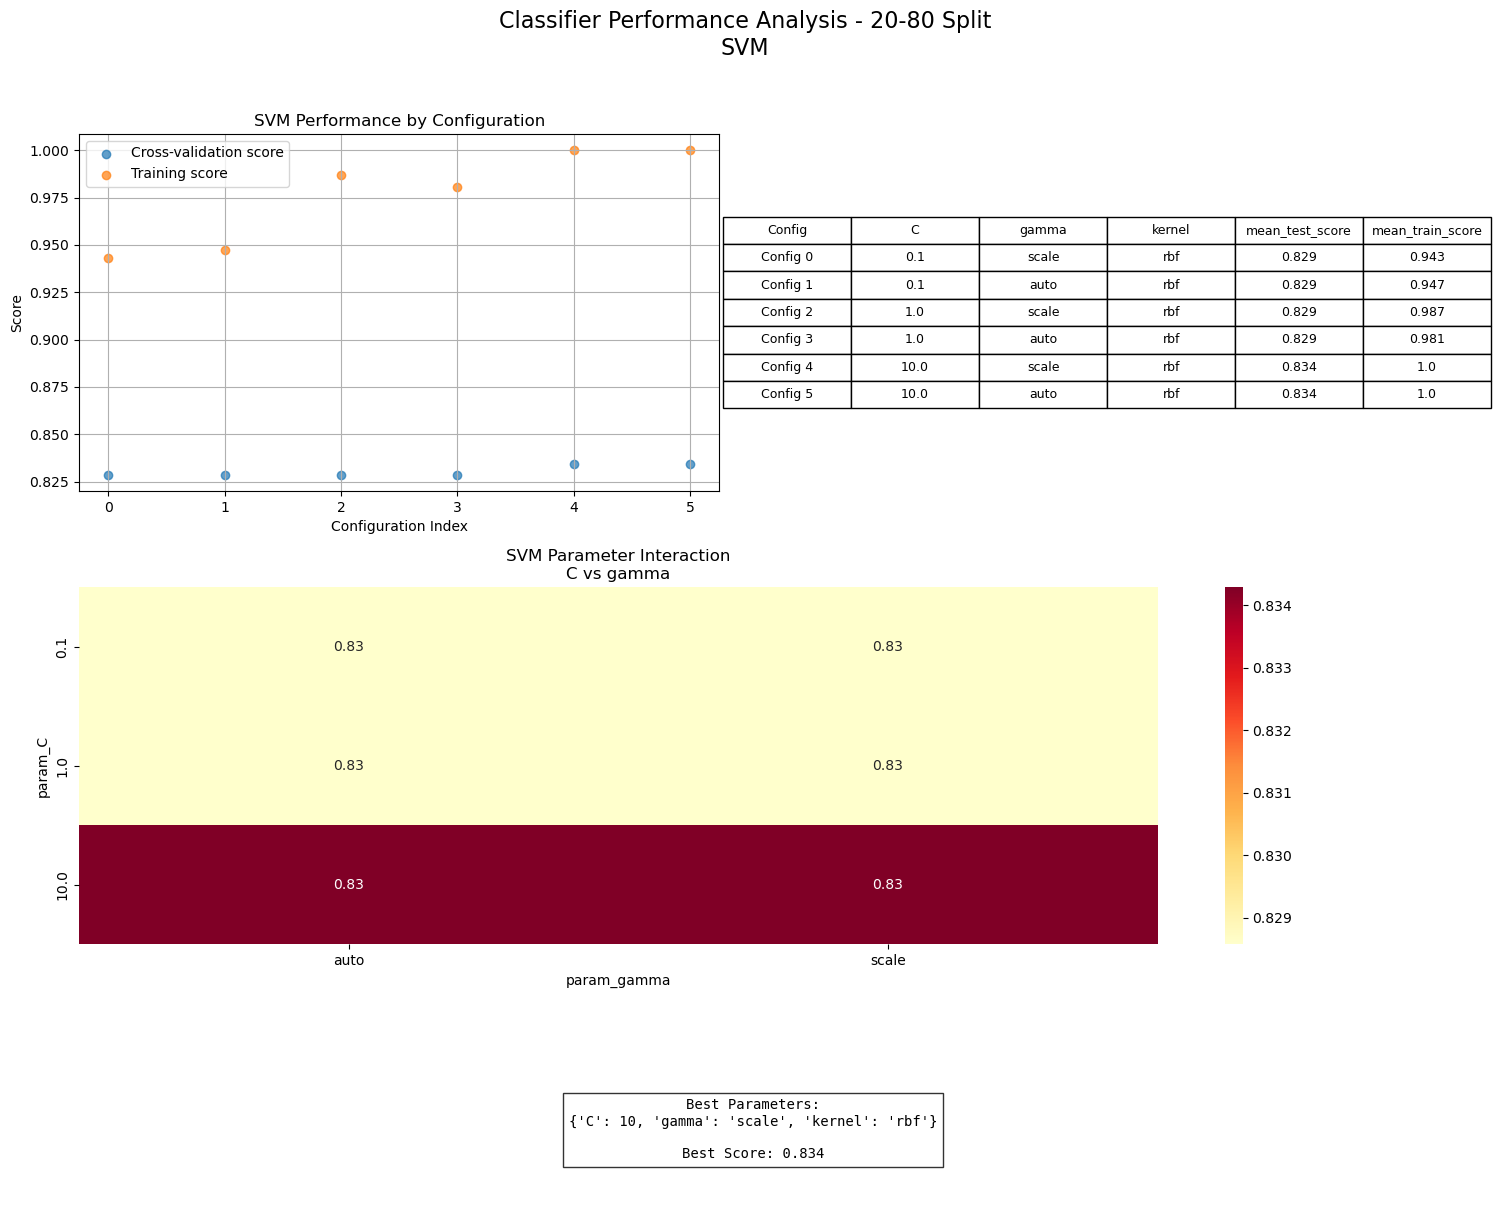


Processing split: 50-50


Trial 1, Split 50-50: 100%|██████████| 3/3 [00:10<00:00,  3.60s/it]


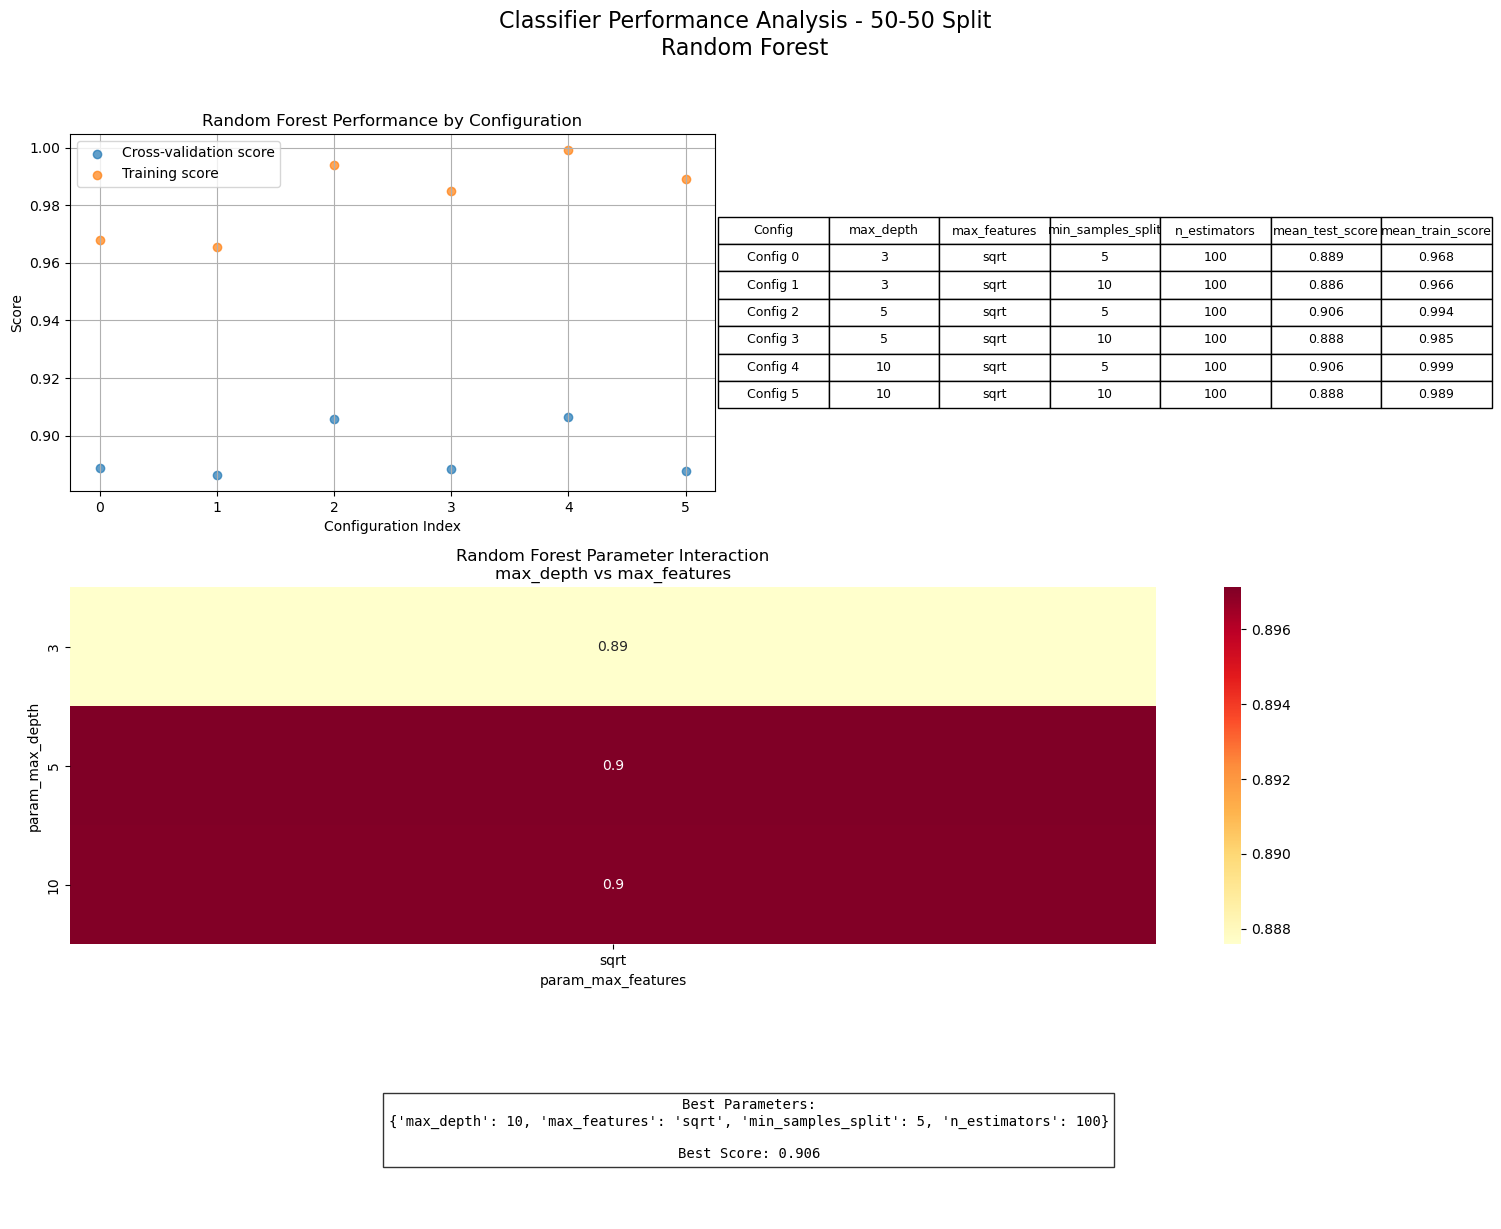

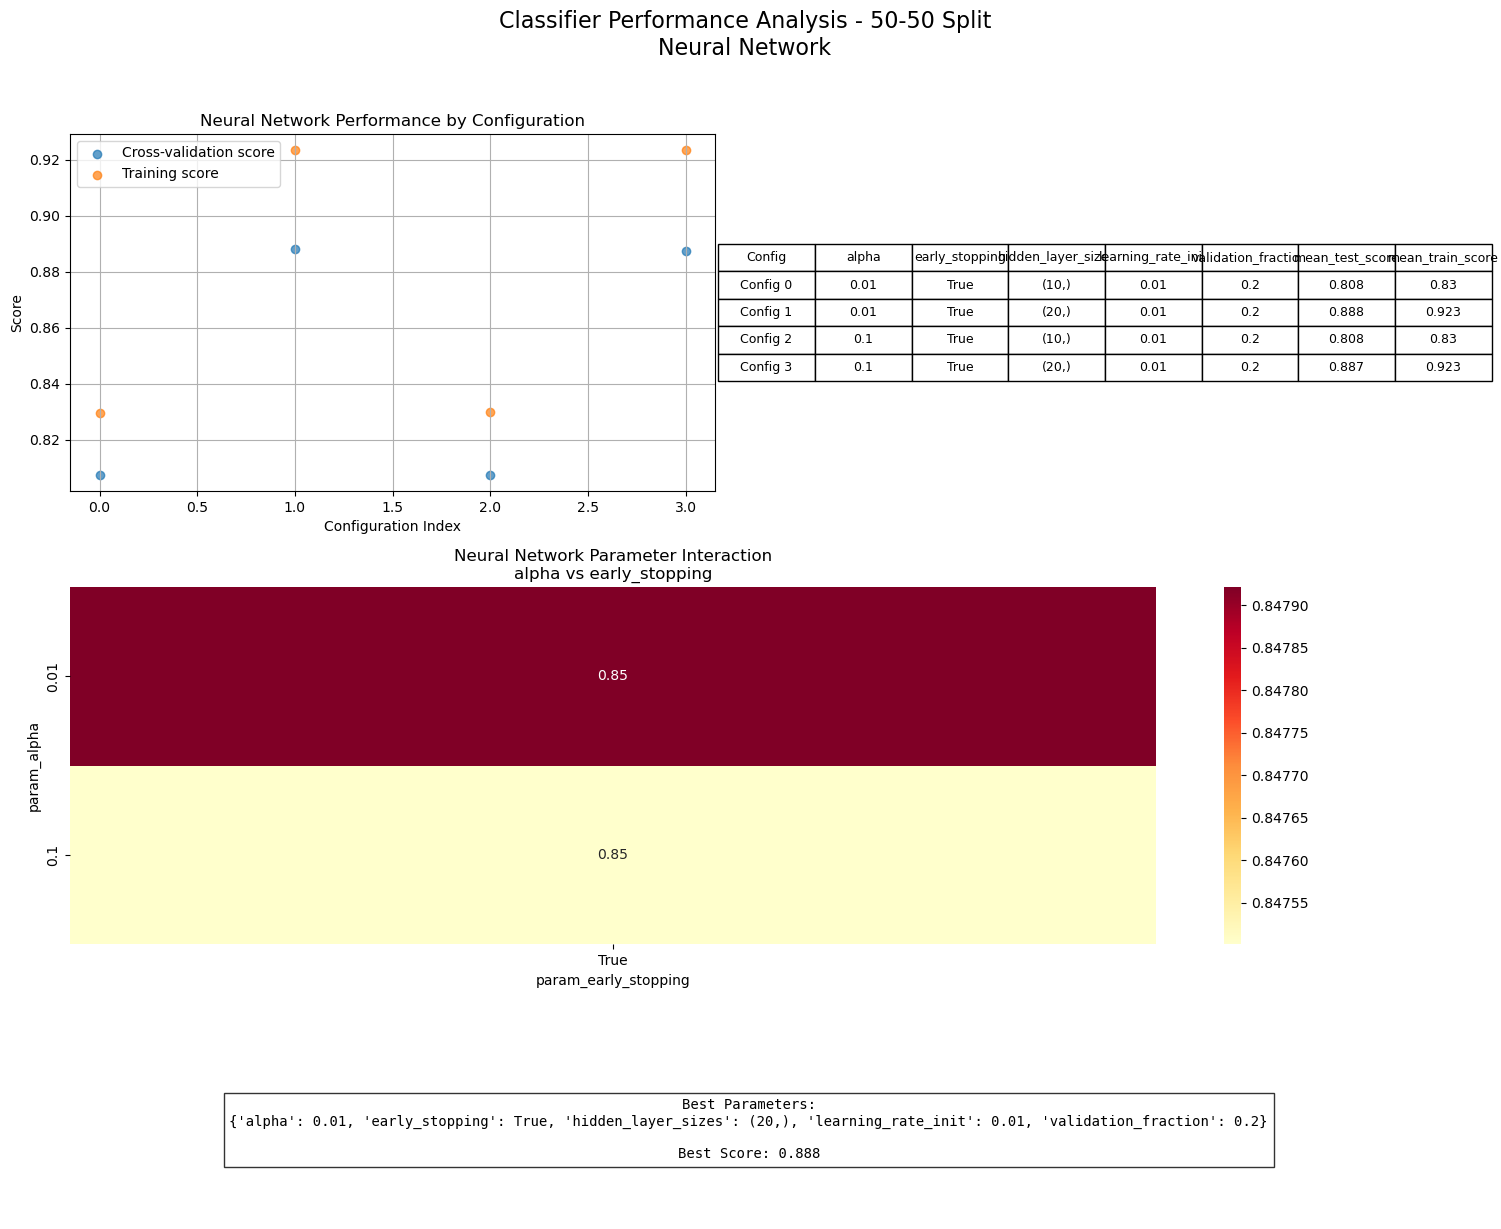

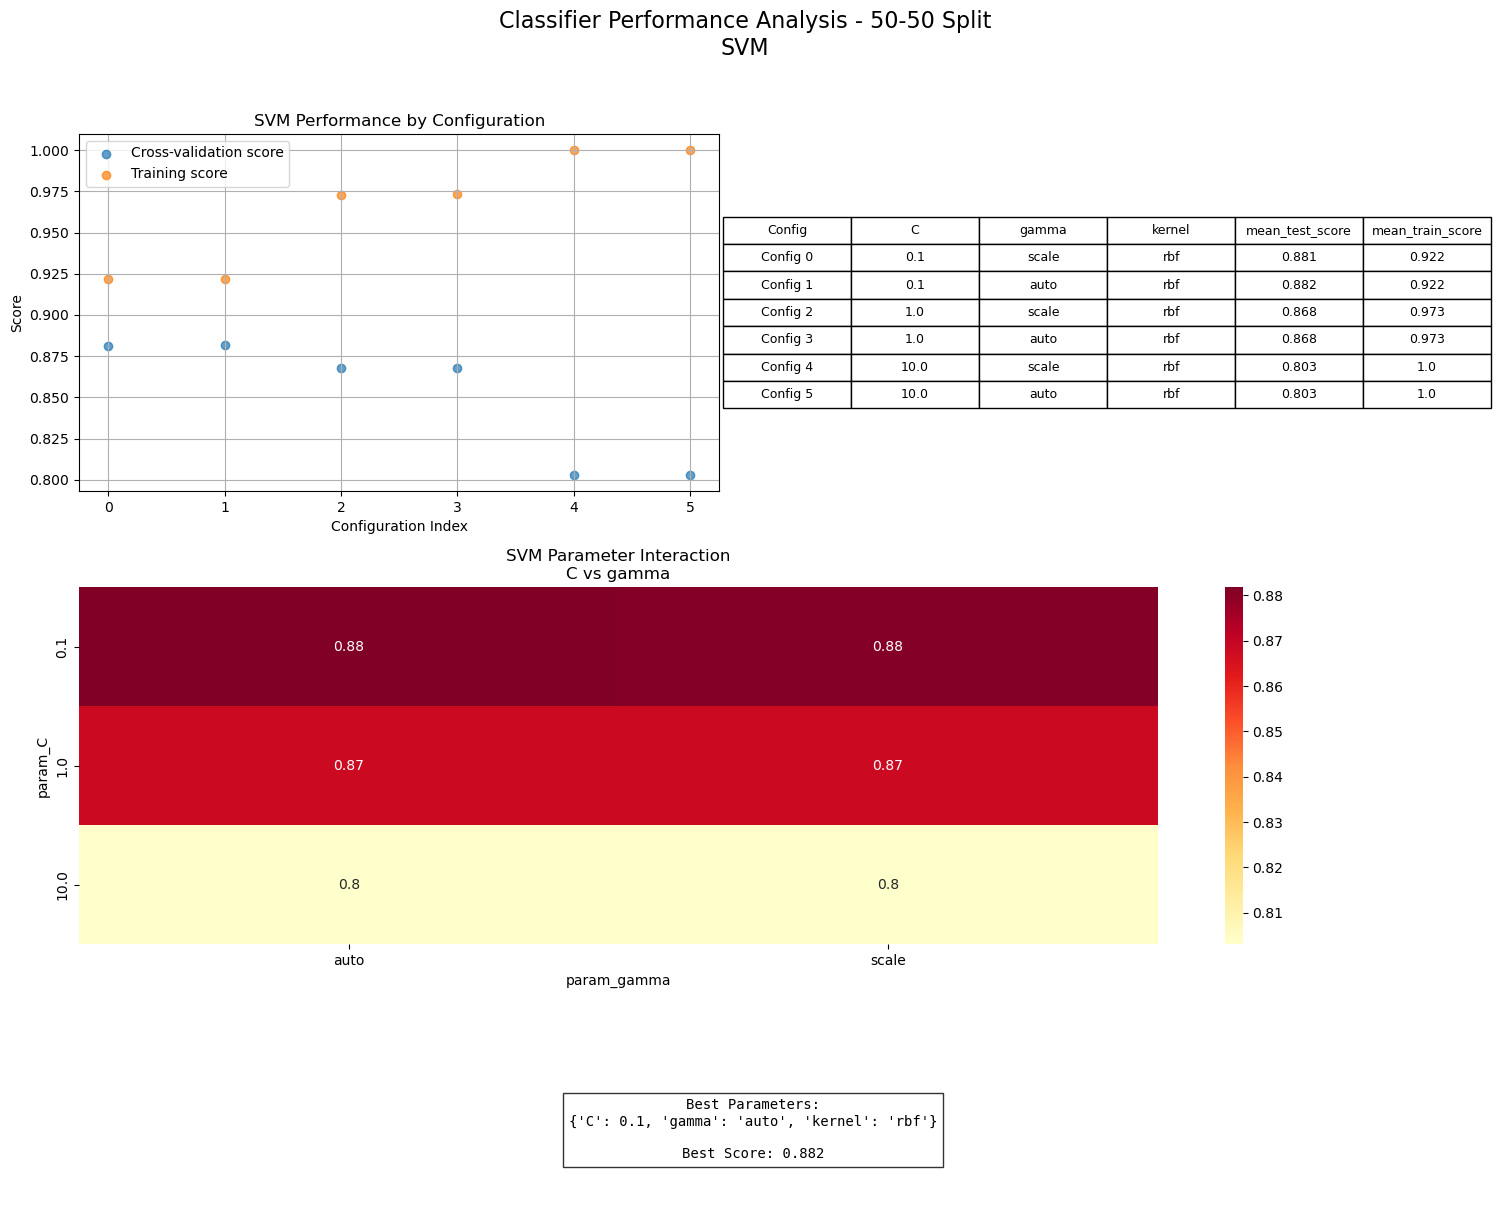


Processing split: 80-20


Trial 1, Split 80-20: 100%|██████████| 3/3 [00:06<00:00,  2.11s/it]


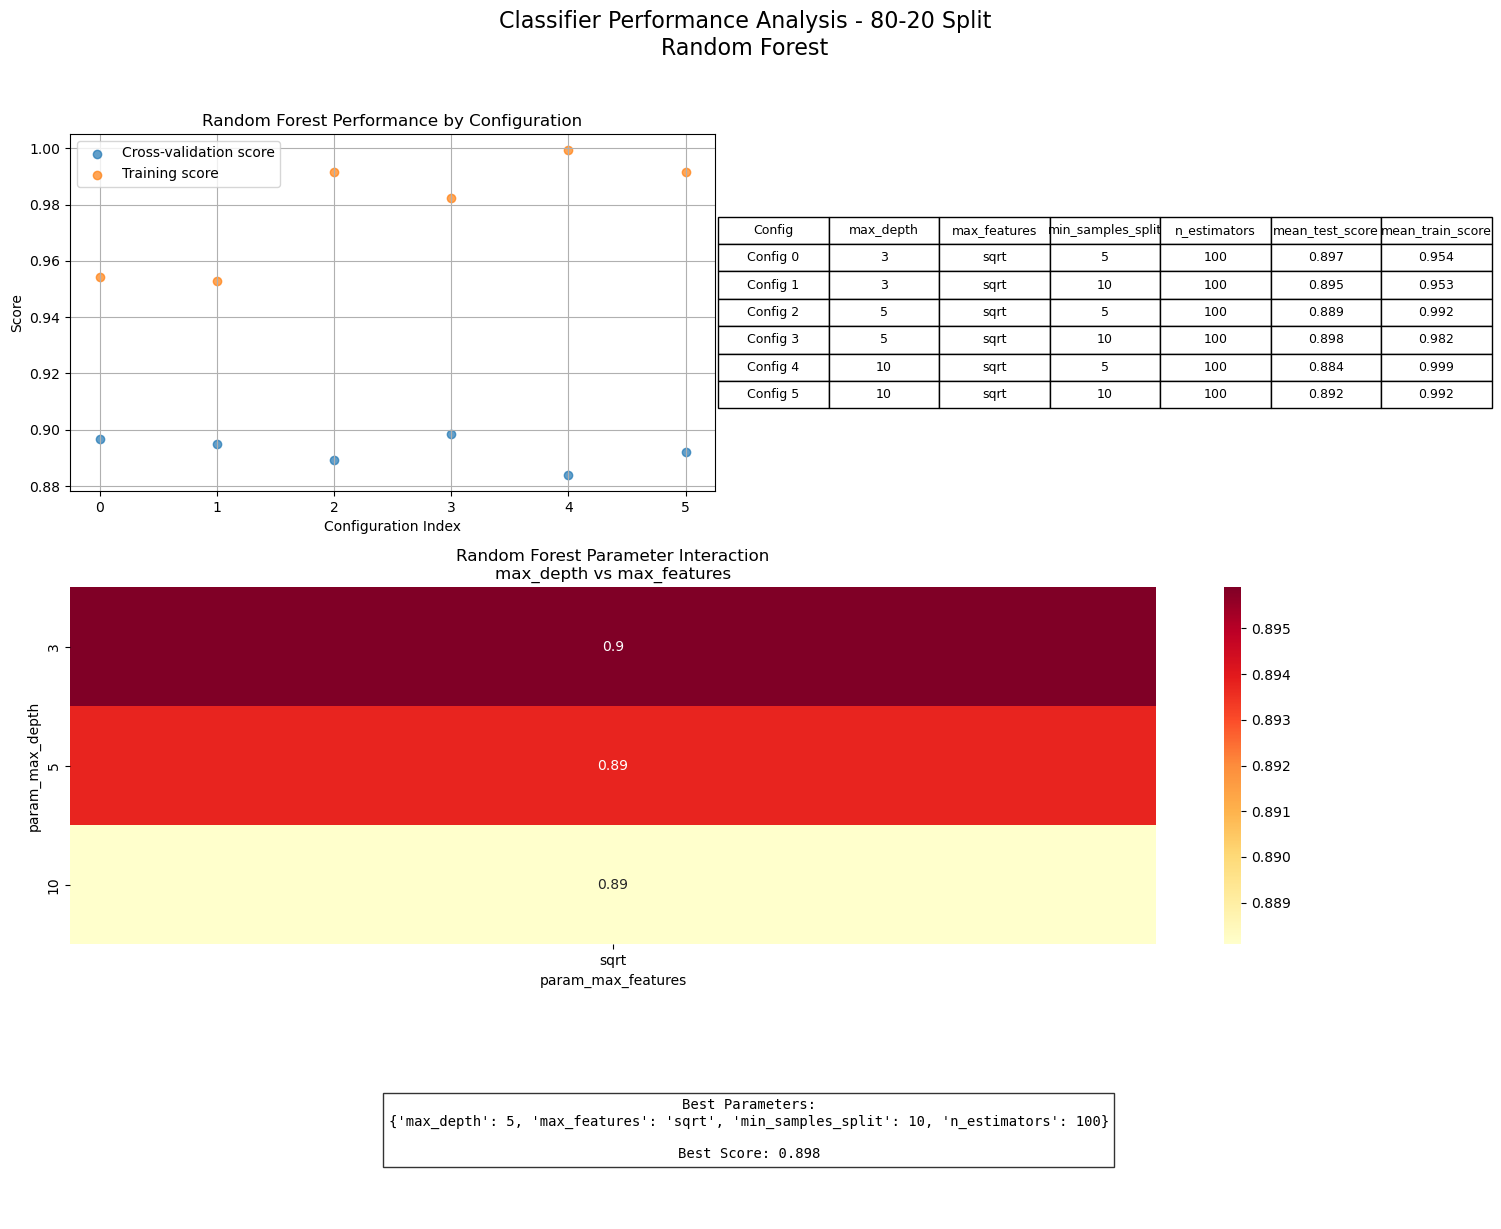

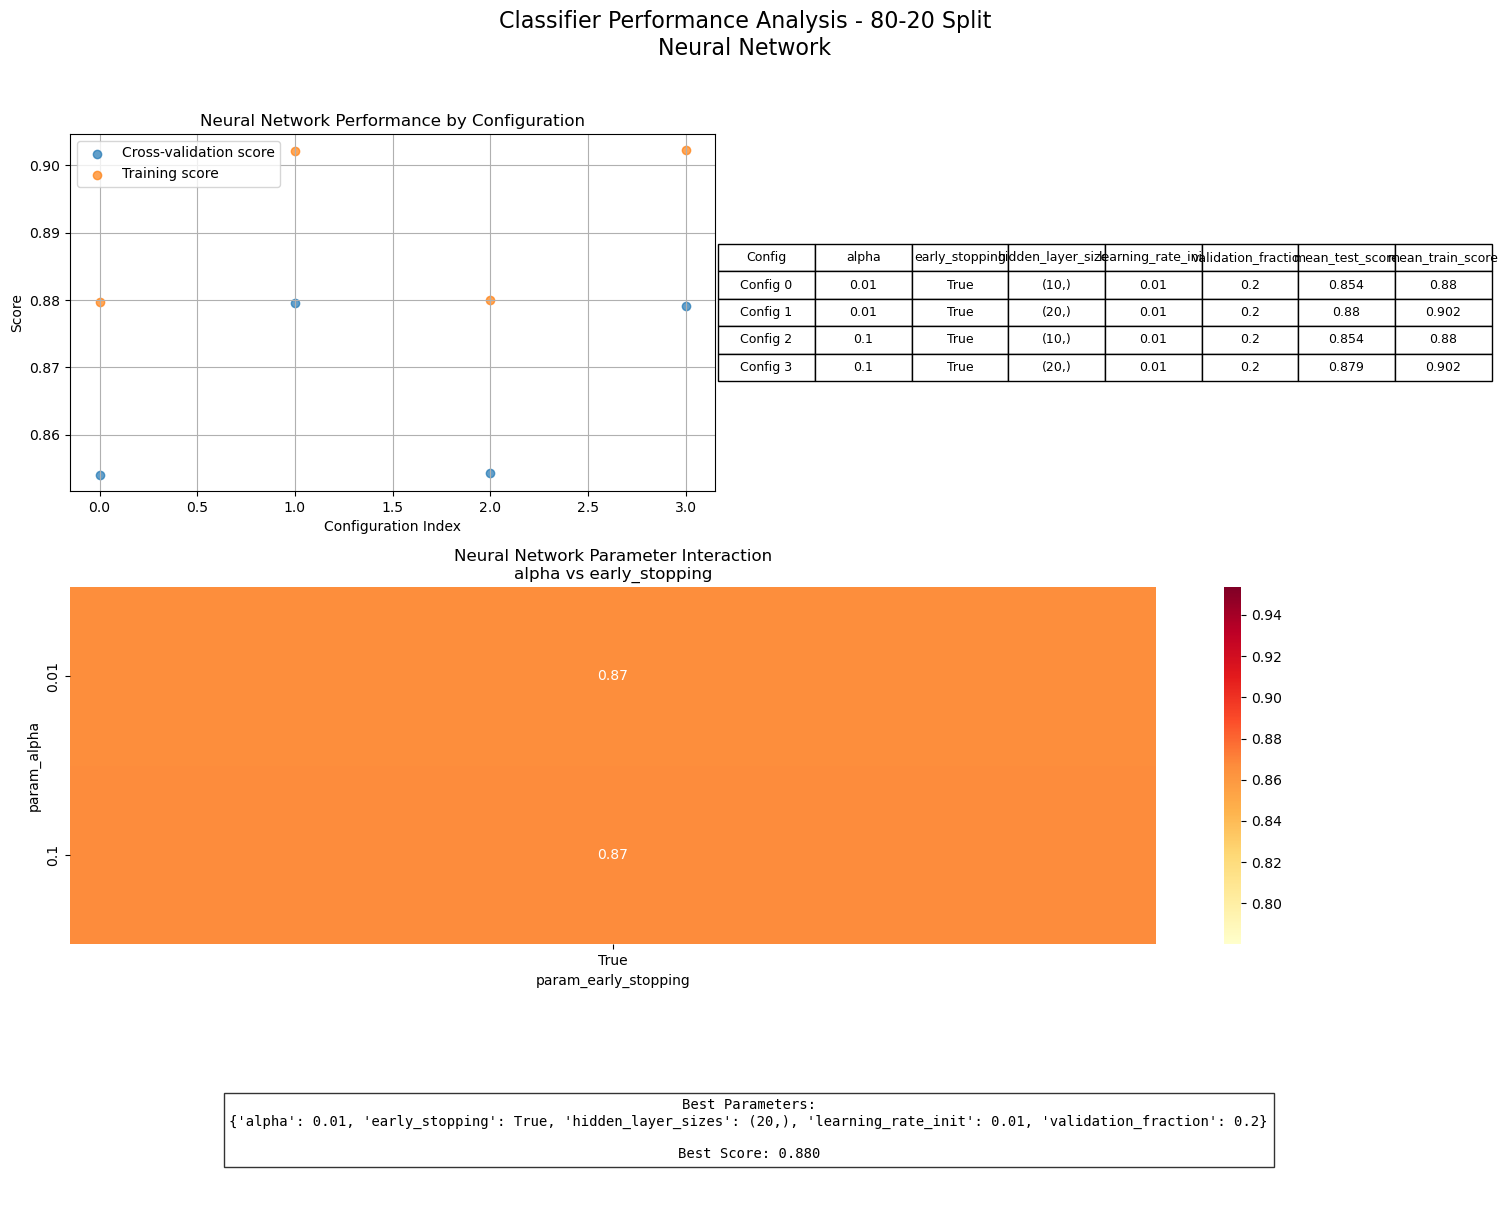

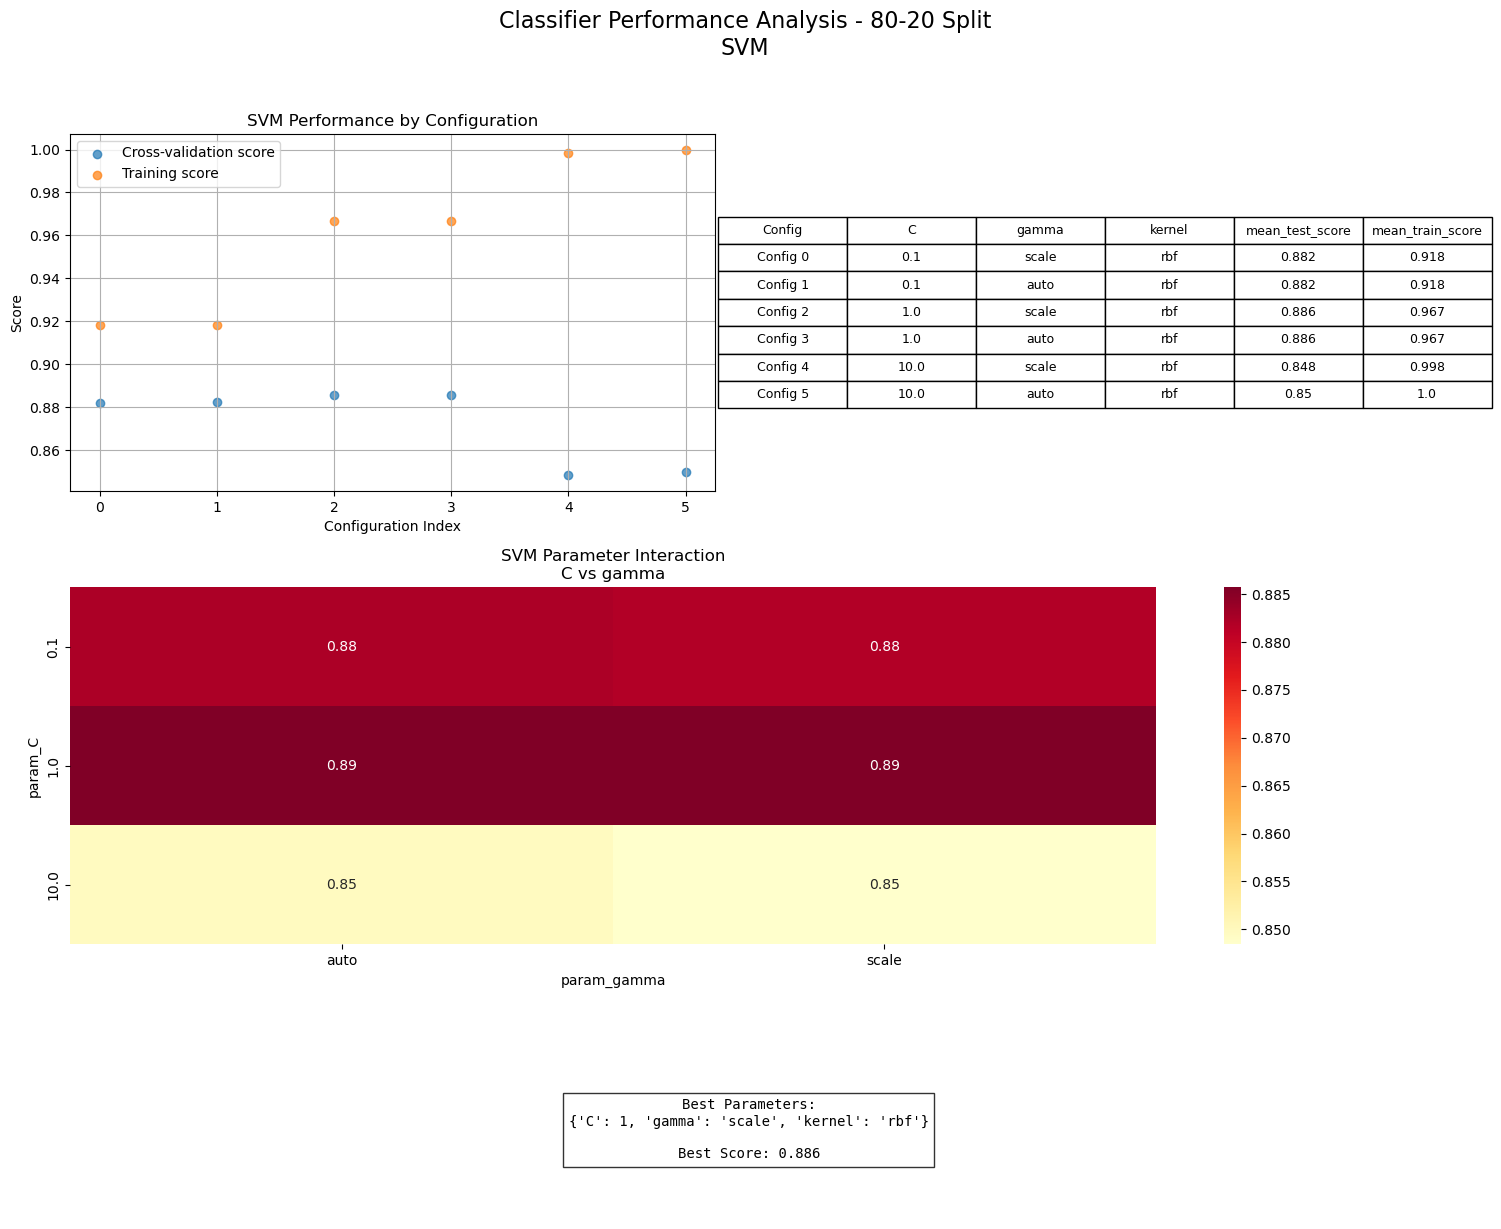


Processing split: 20-80


Trial 2, Split 20-80: 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]


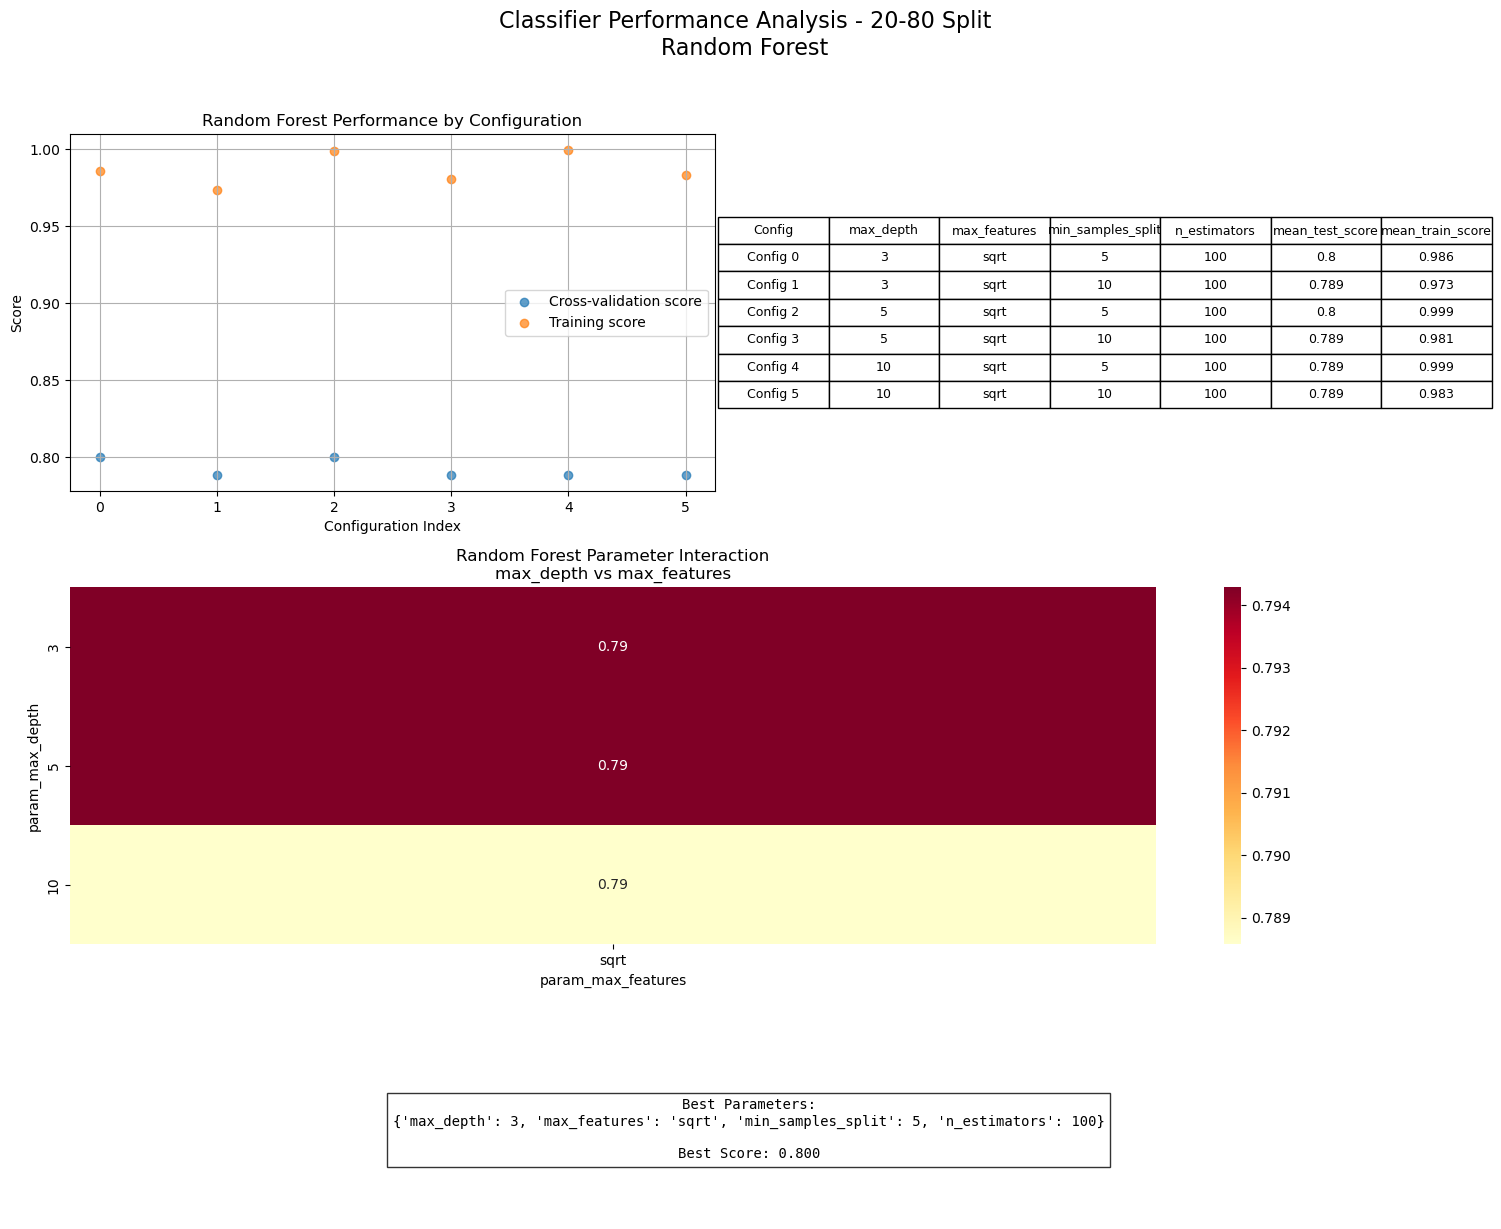

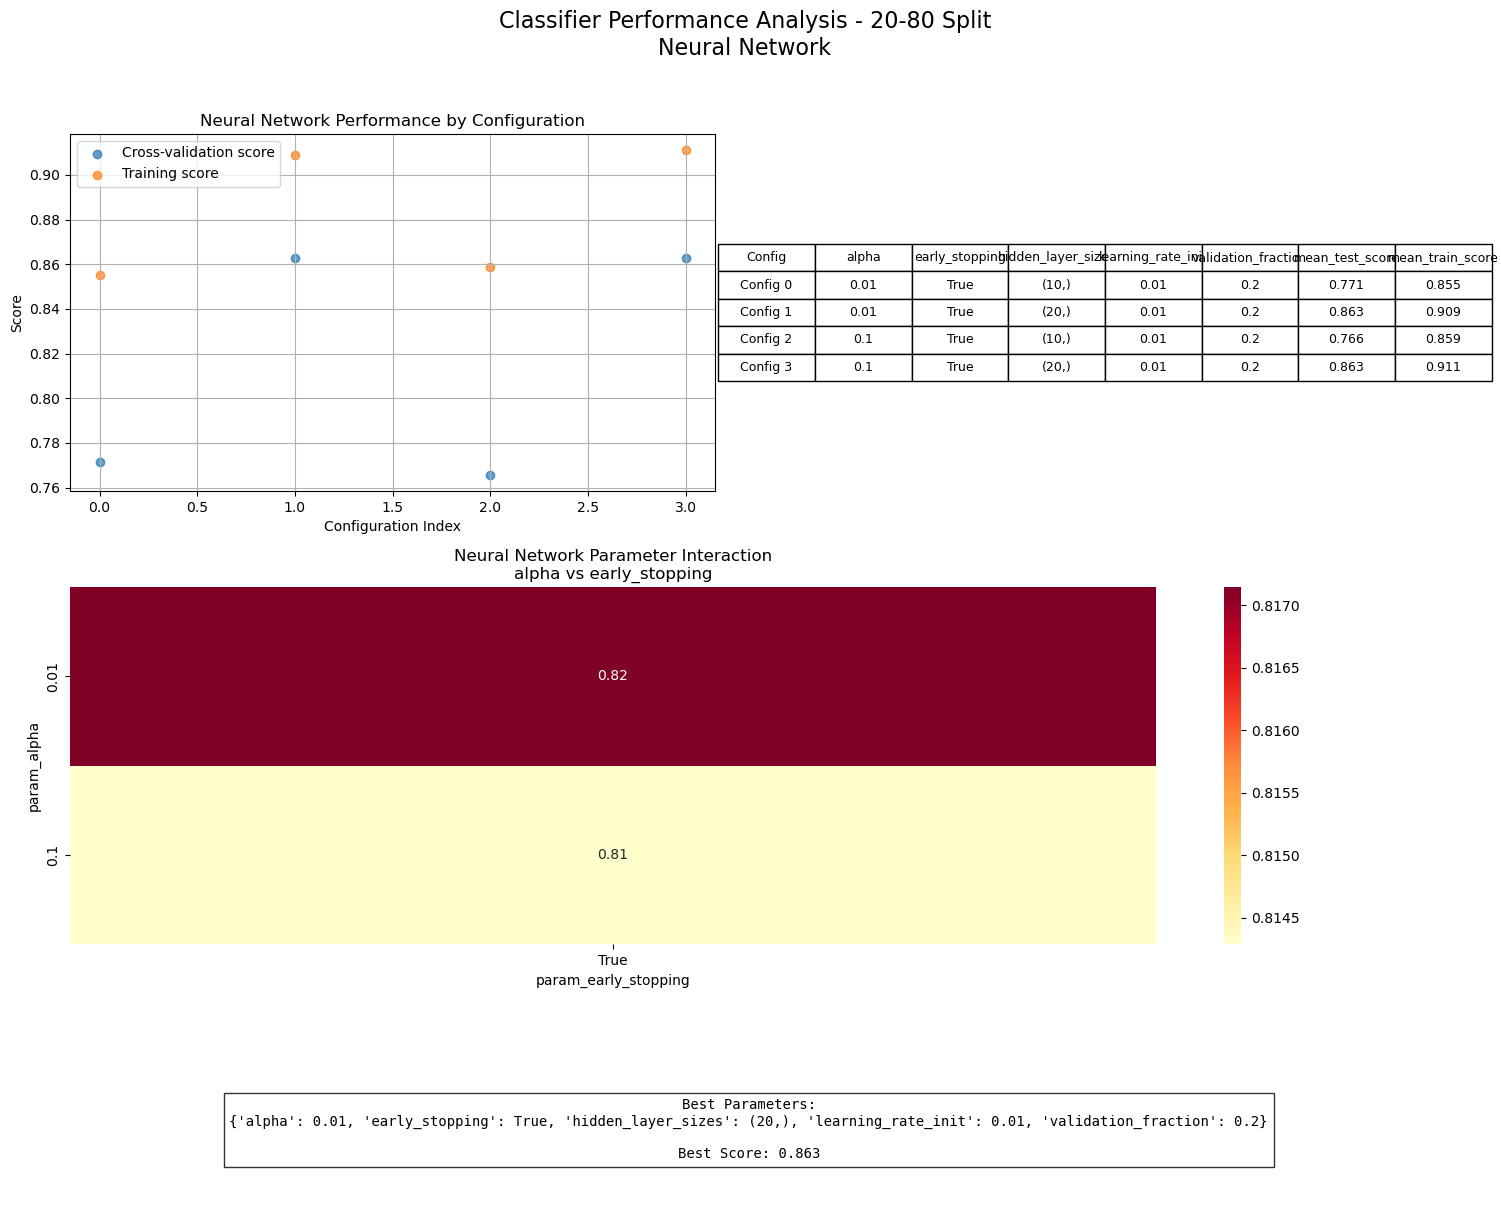

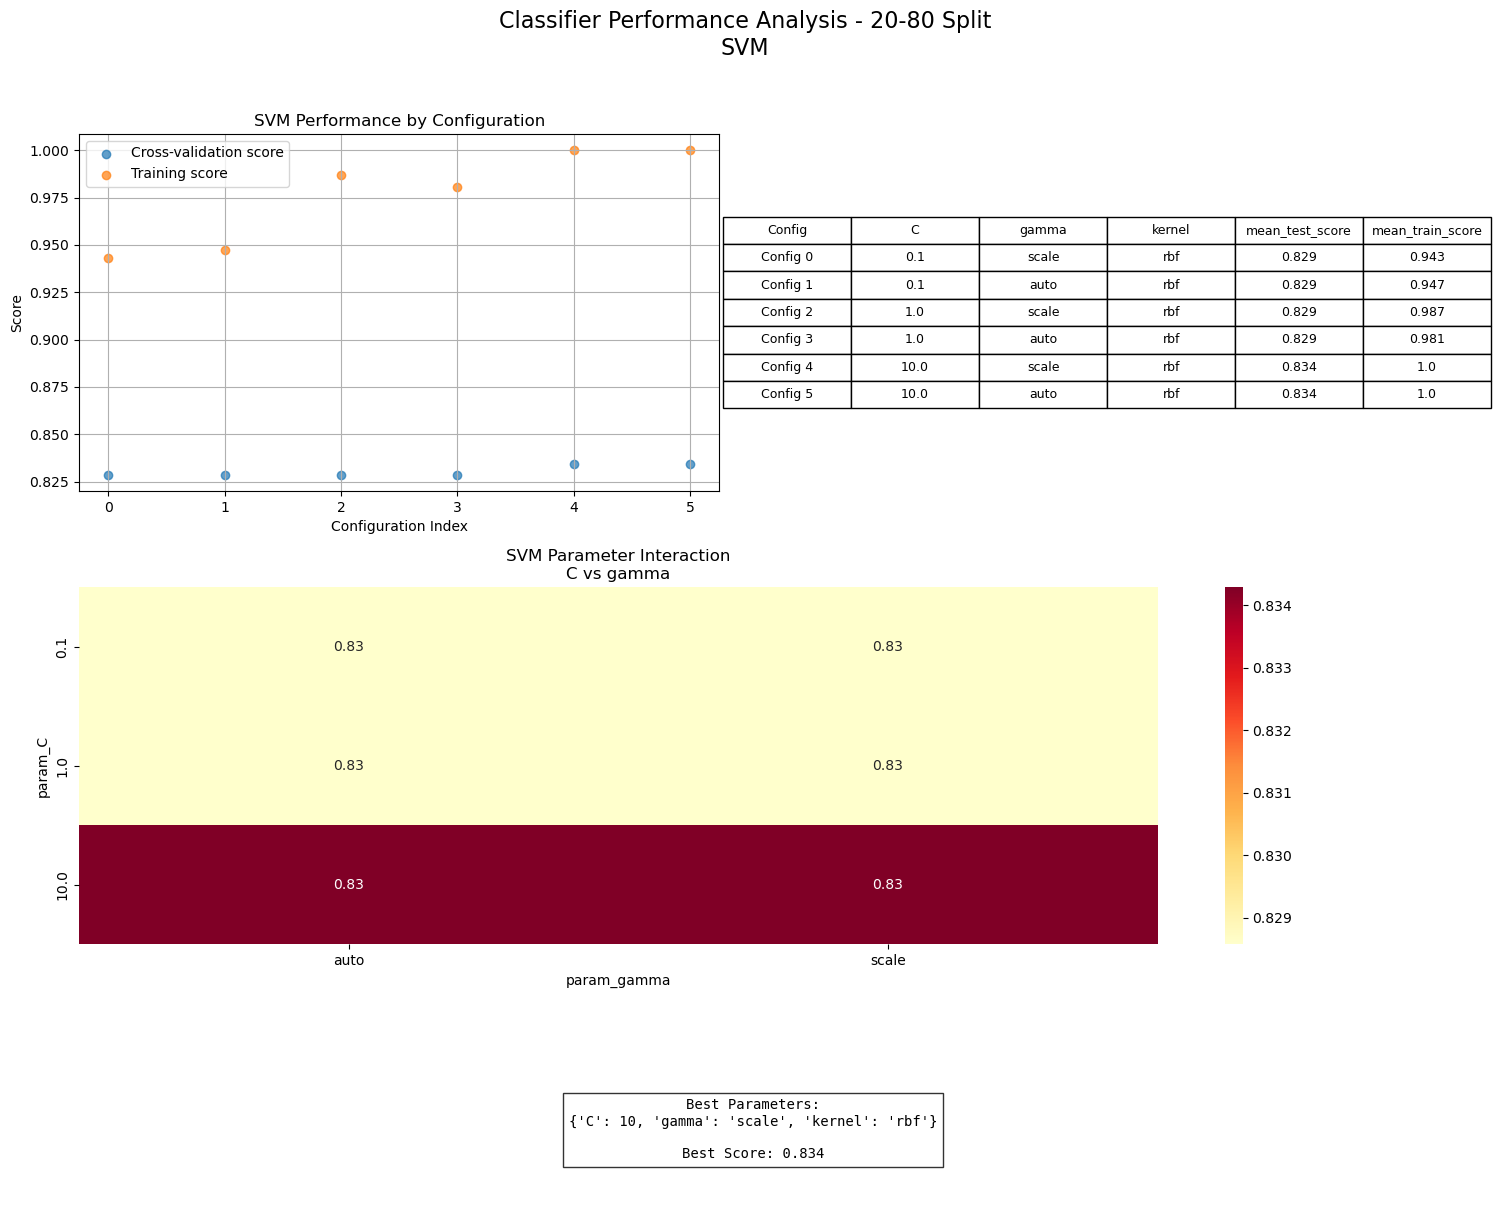


Processing split: 50-50


Trial 2, Split 50-50: 100%|██████████| 3/3 [00:07<00:00,  2.45s/it]


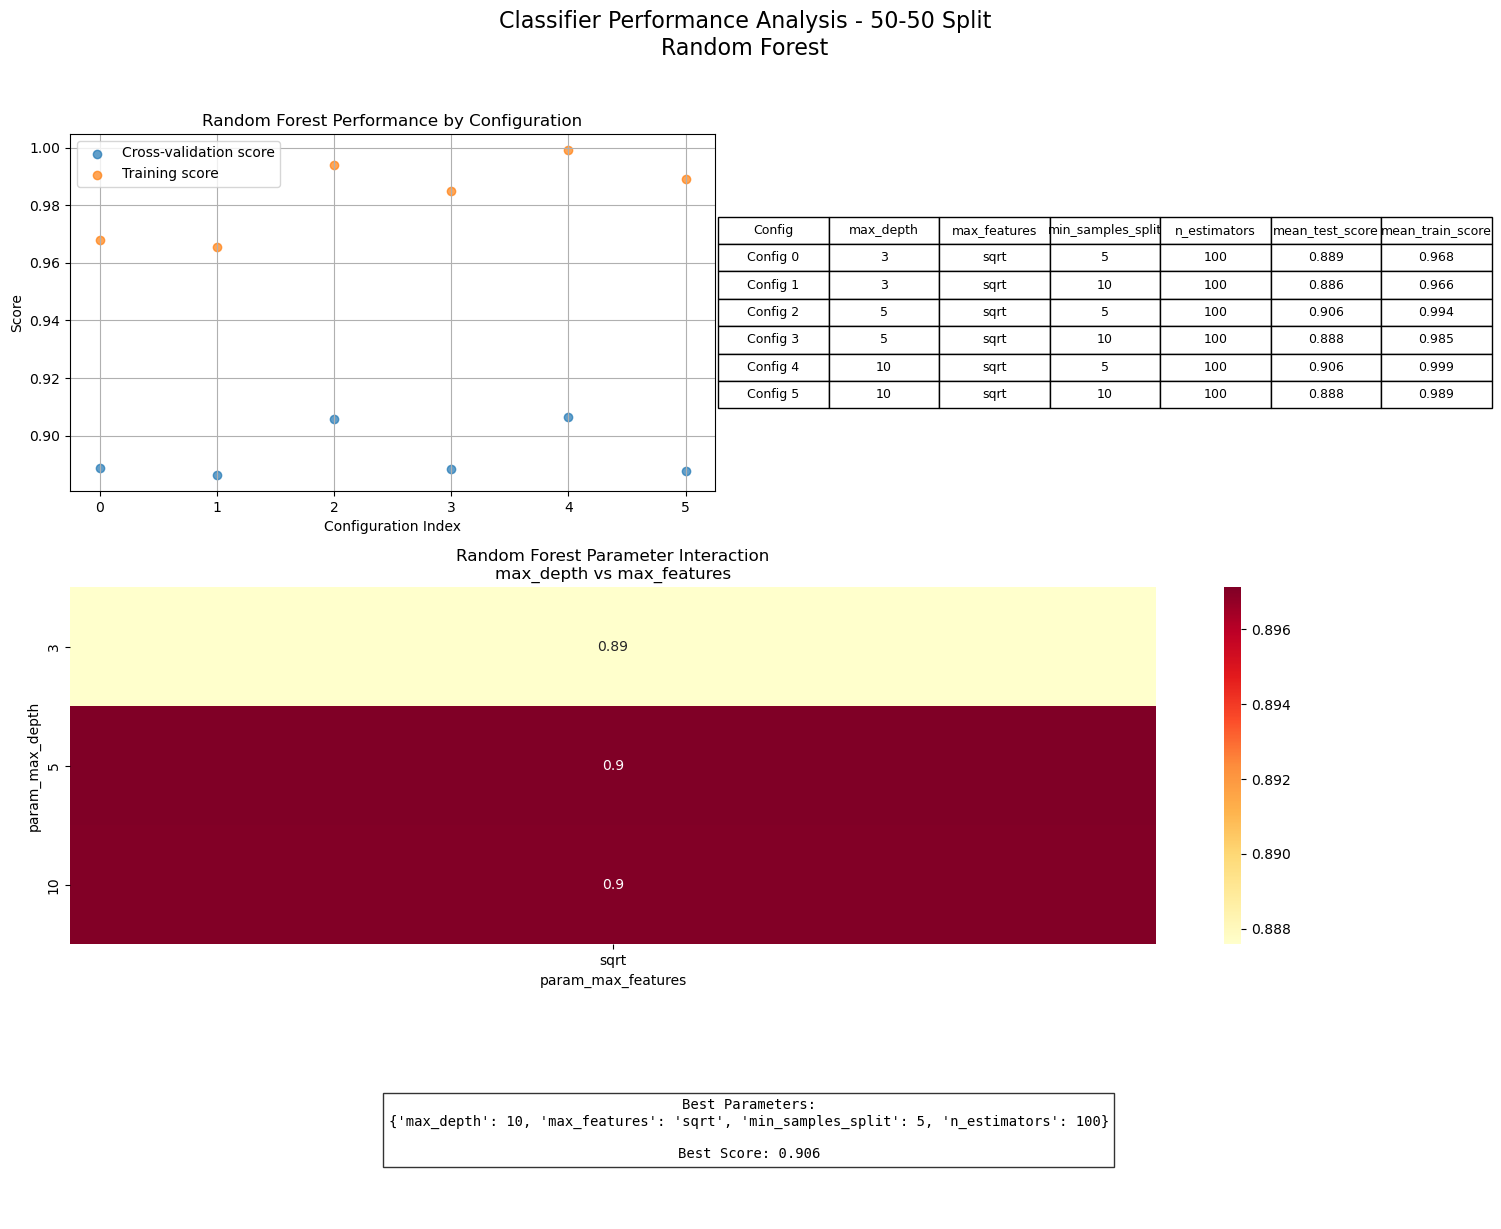

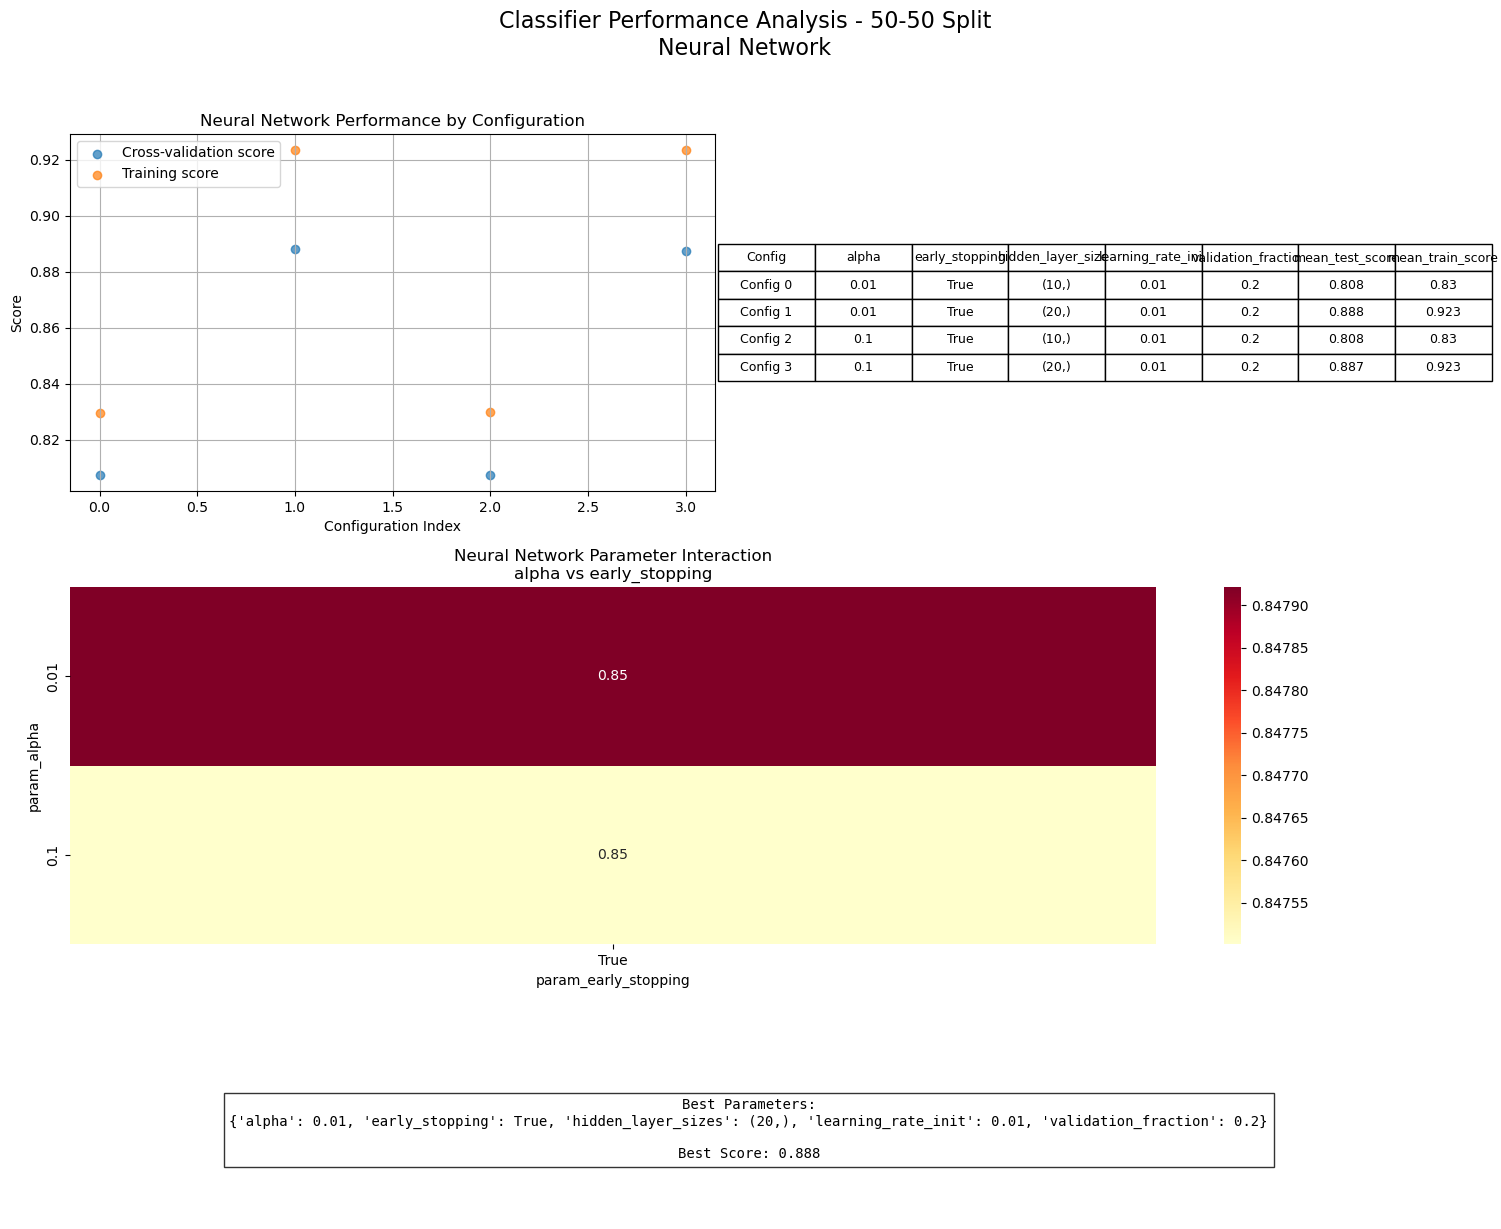

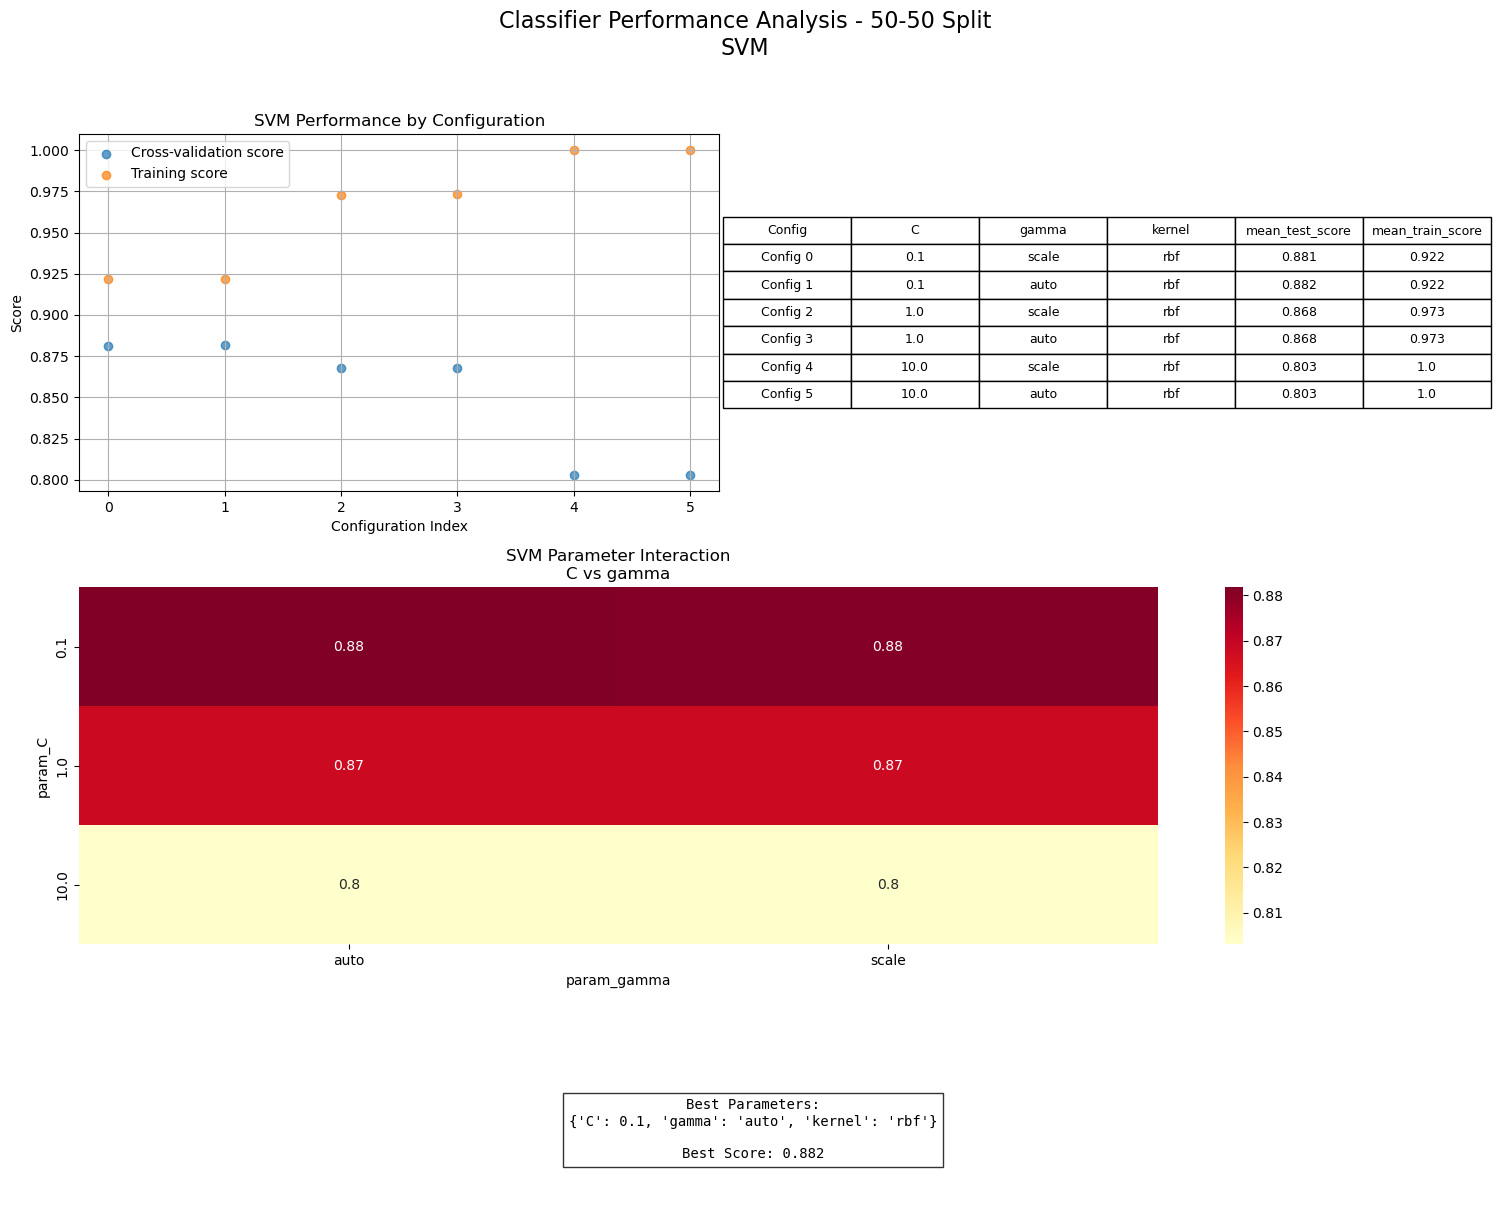


Processing split: 80-20


Trial 2, Split 80-20: 100%|██████████| 3/3 [00:09<00:00,  3.07s/it]


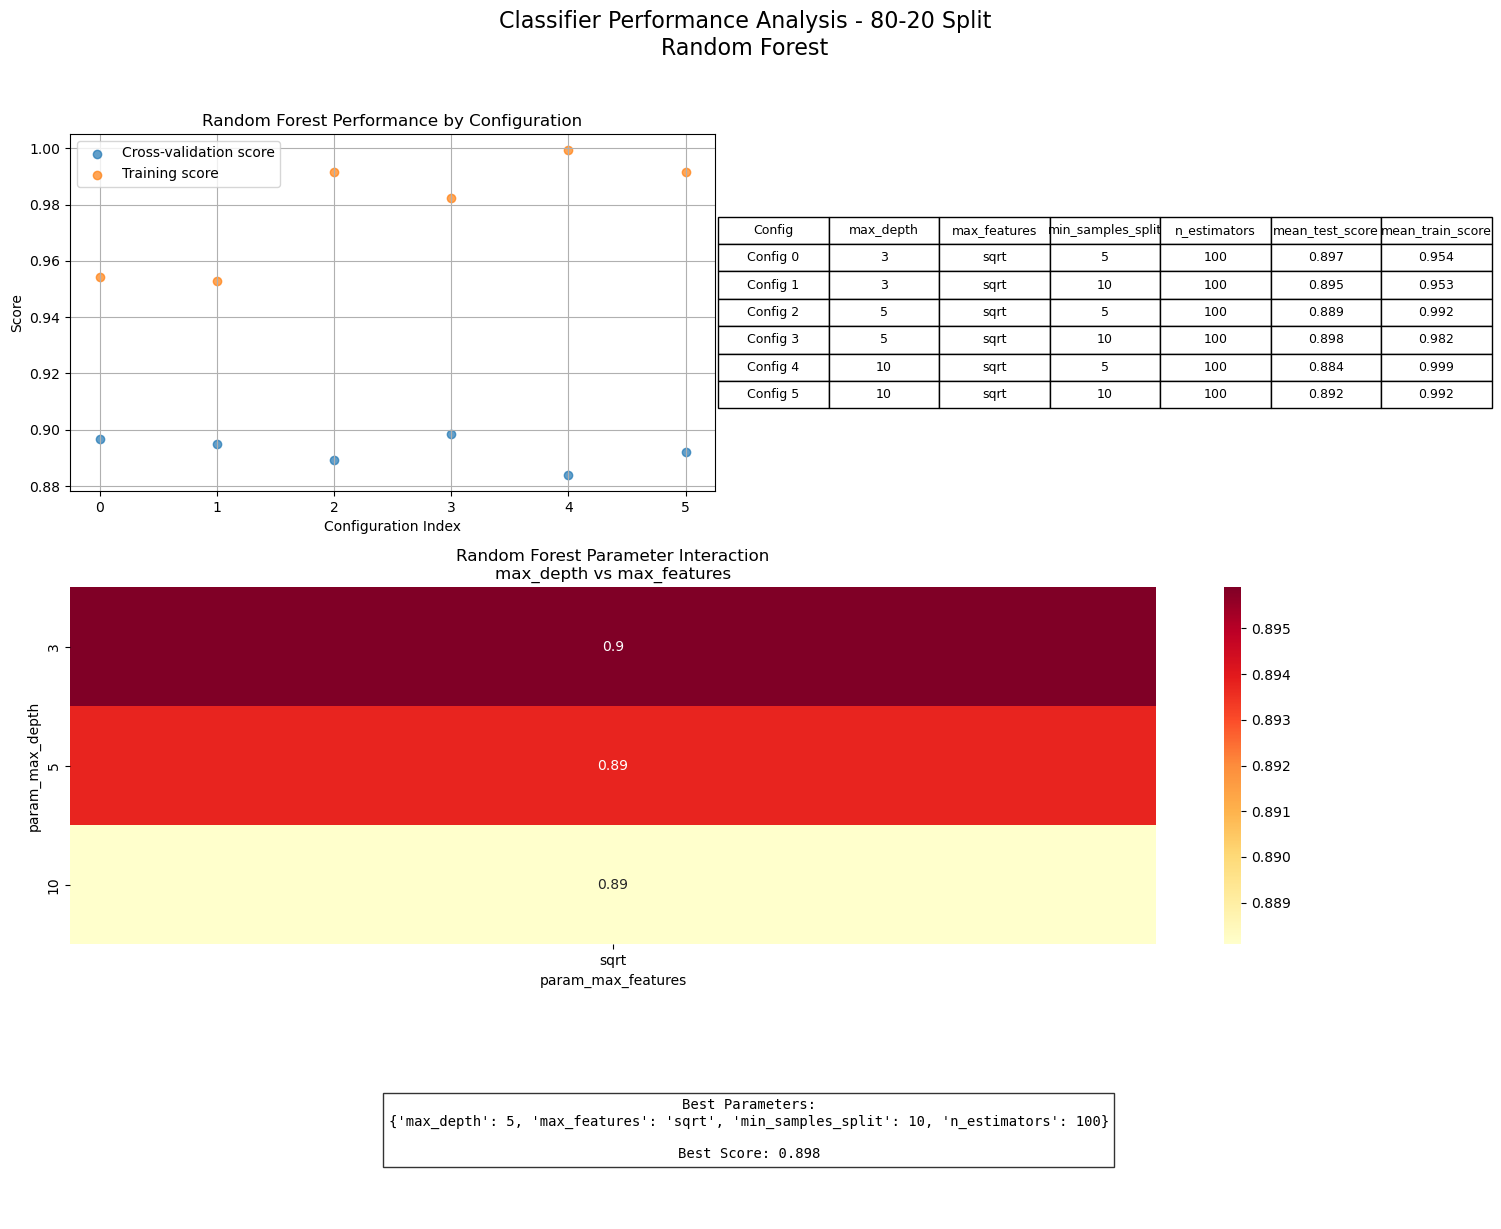

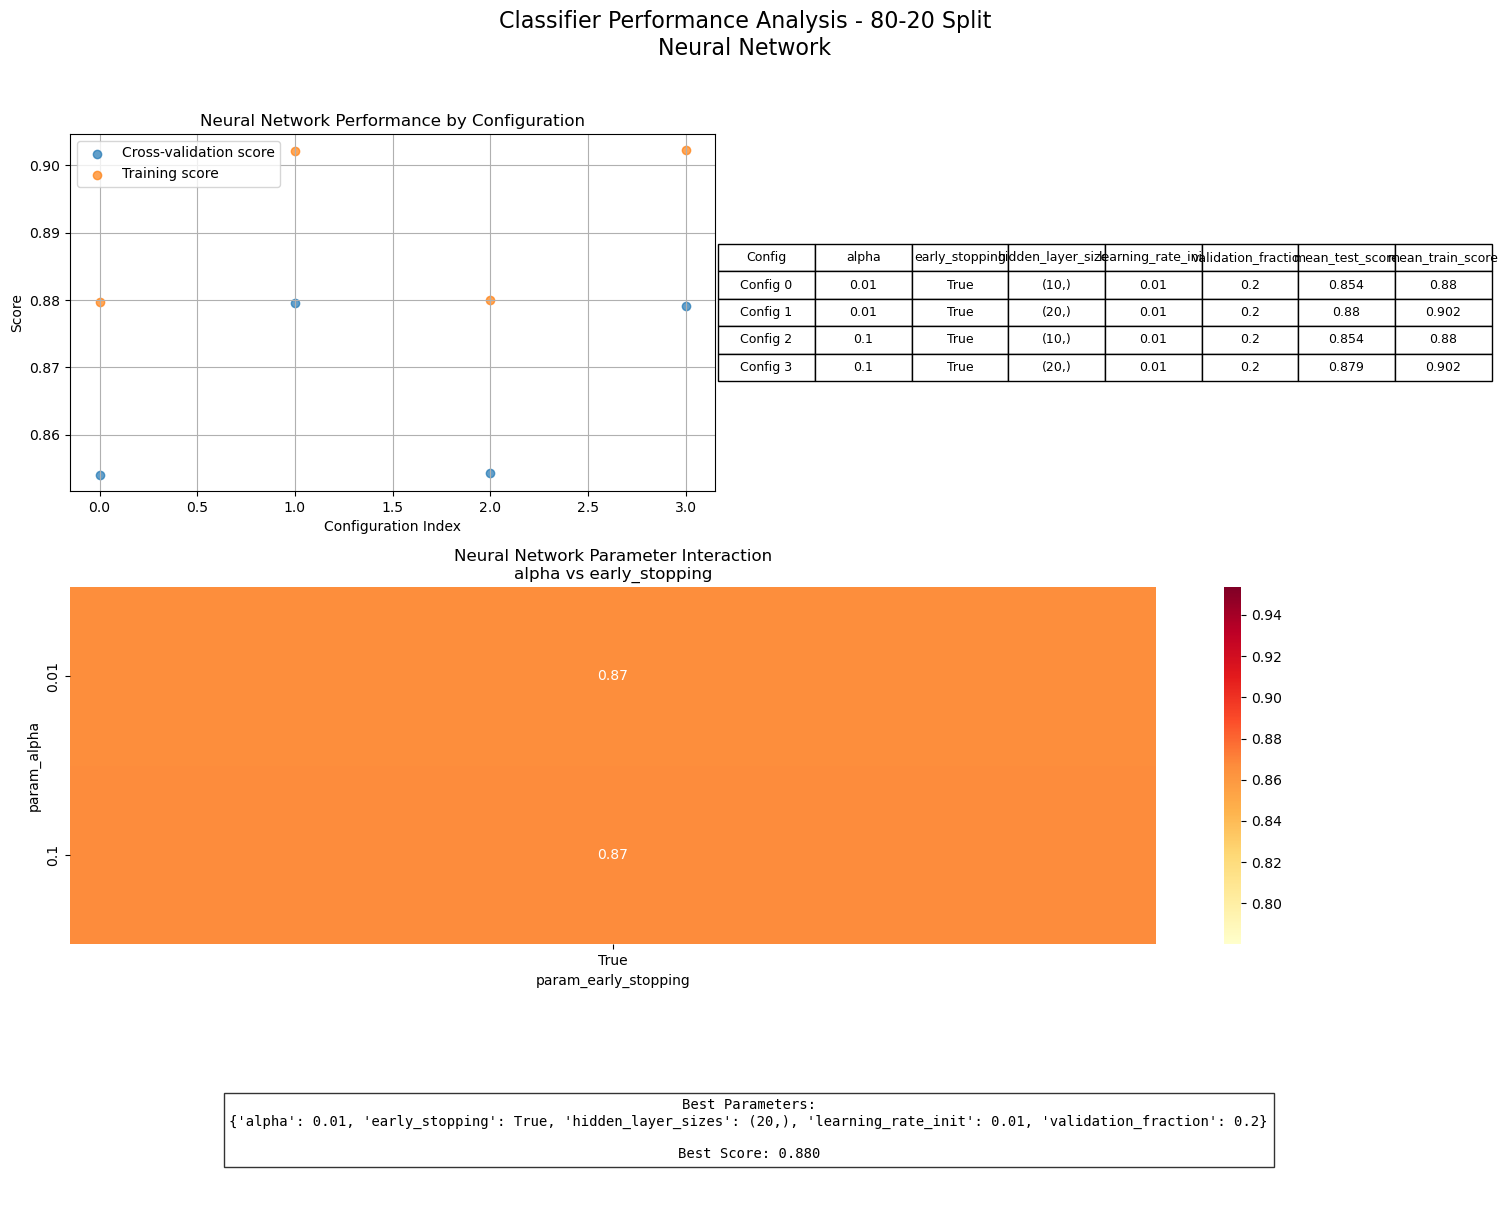

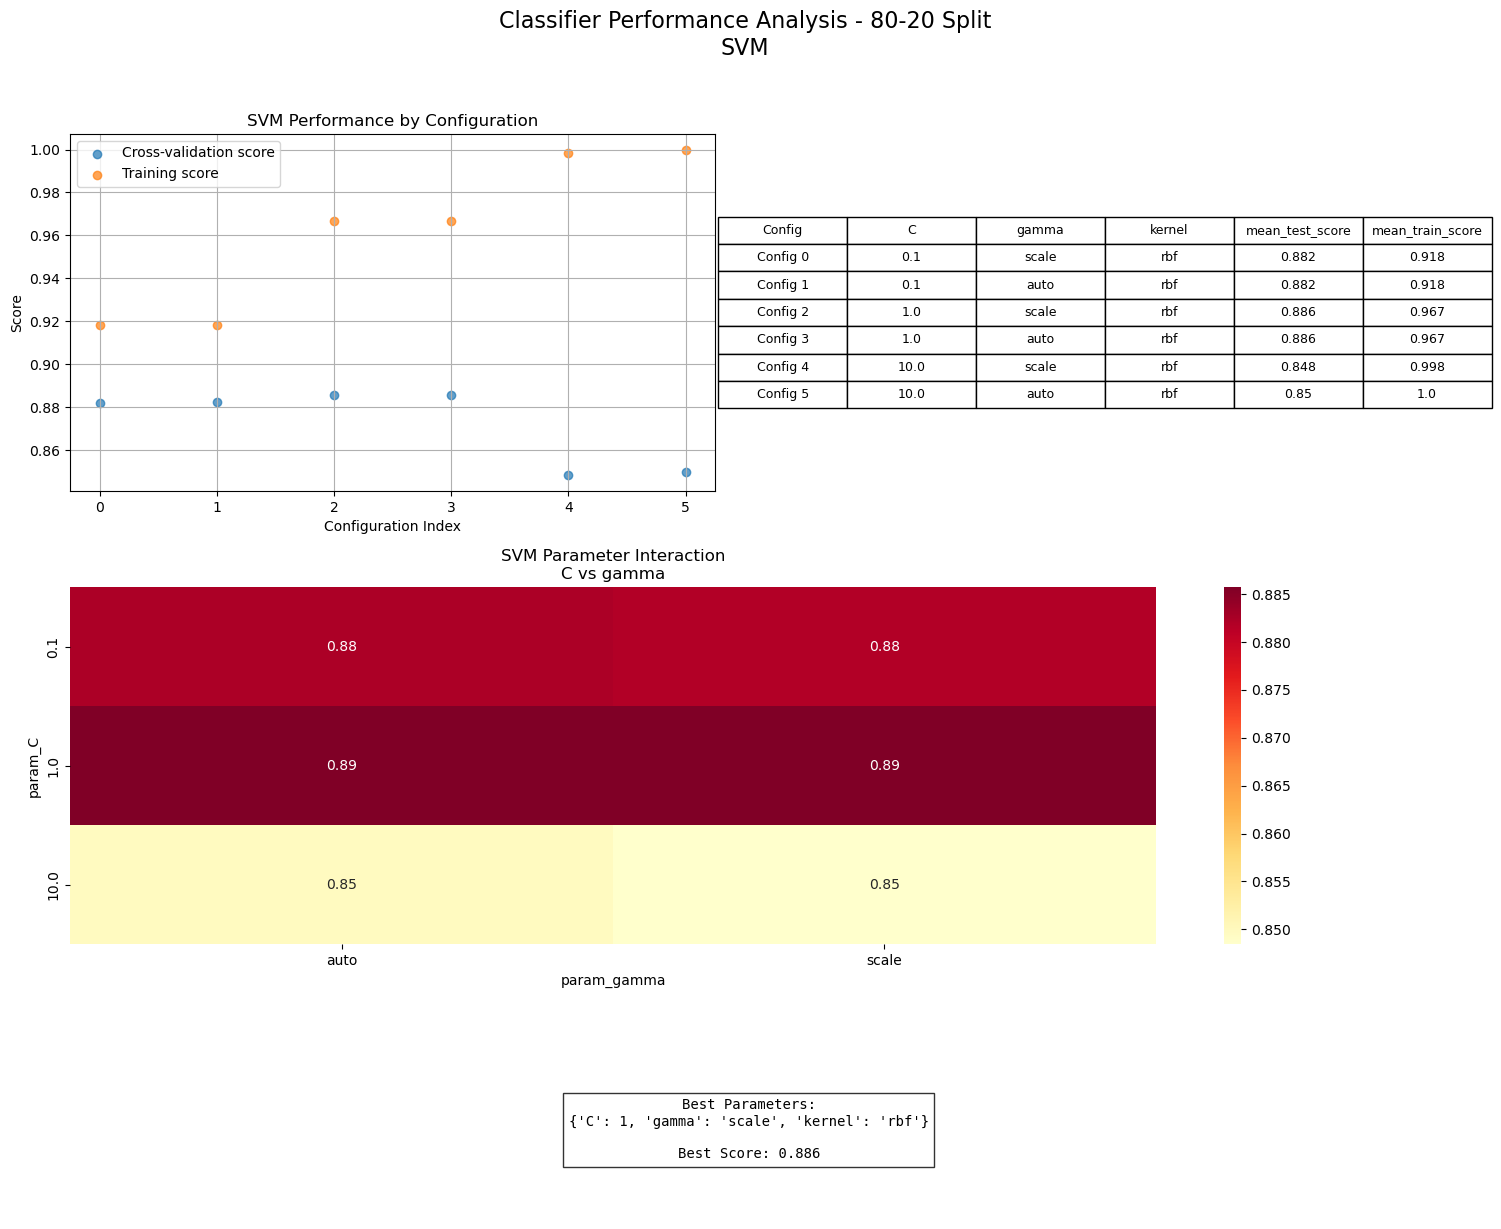


Processing split: 20-80


Trial 3, Split 20-80: 100%|██████████| 3/3 [00:07<00:00,  2.36s/it]


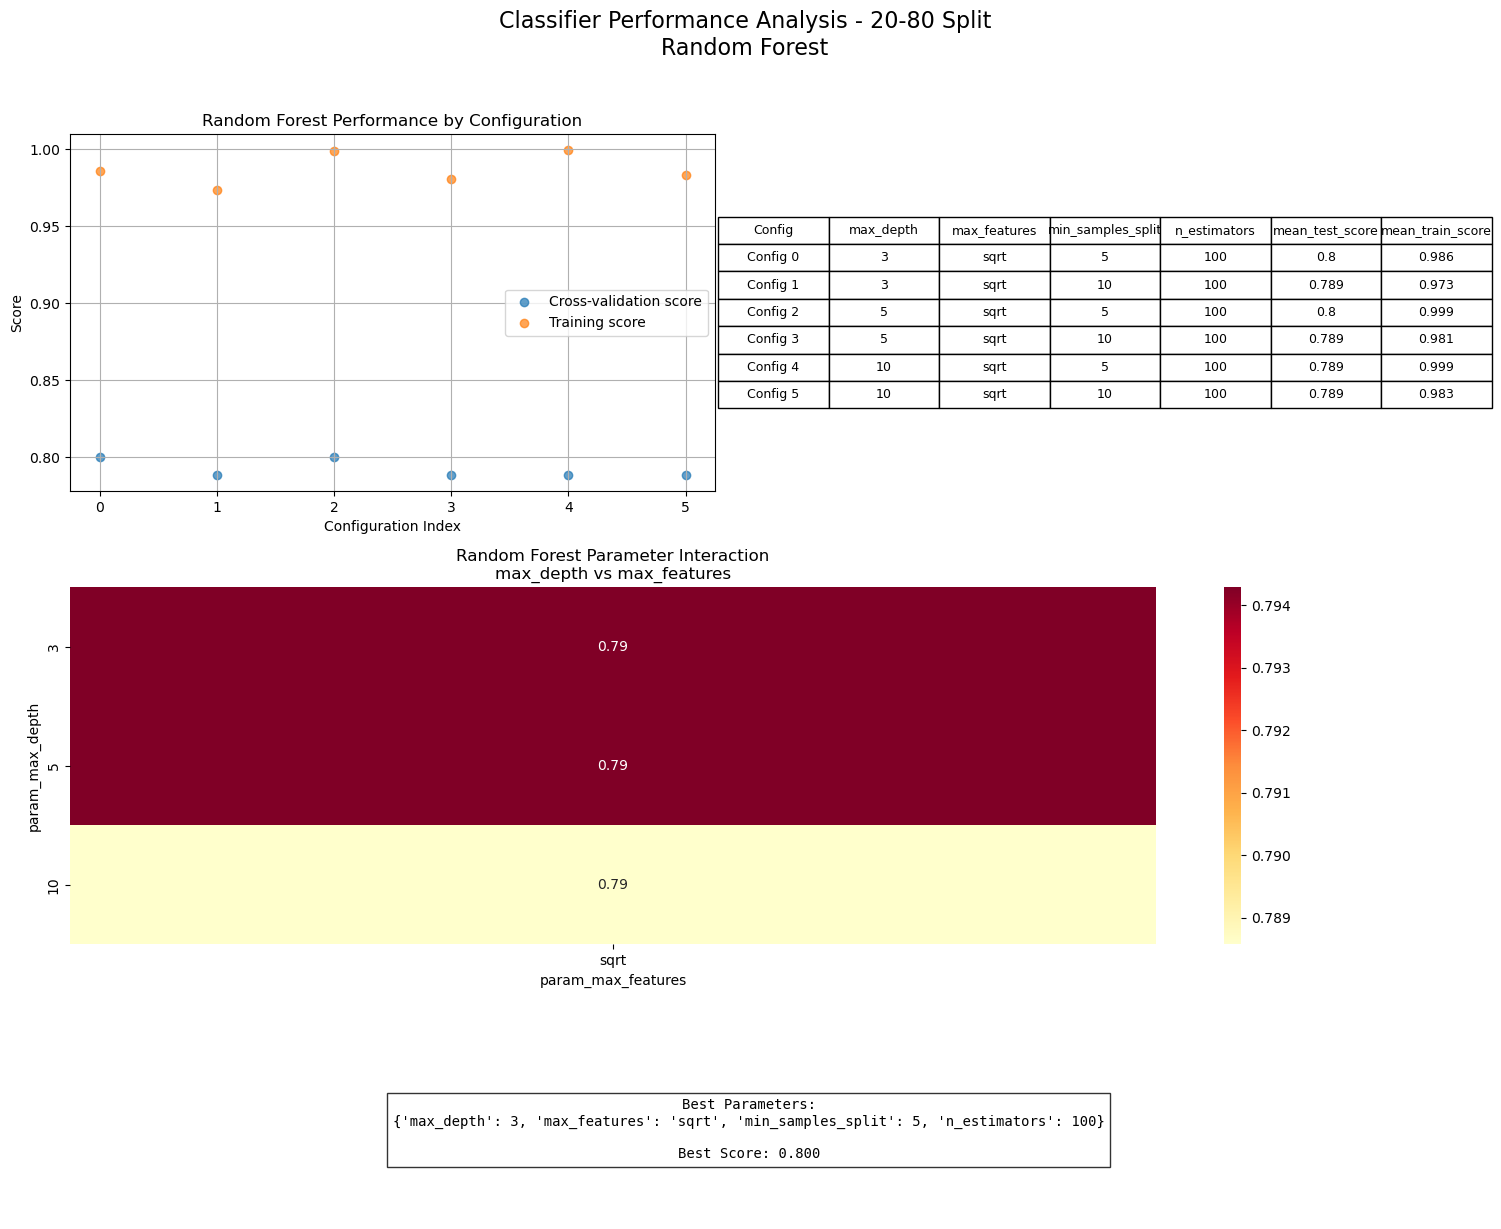

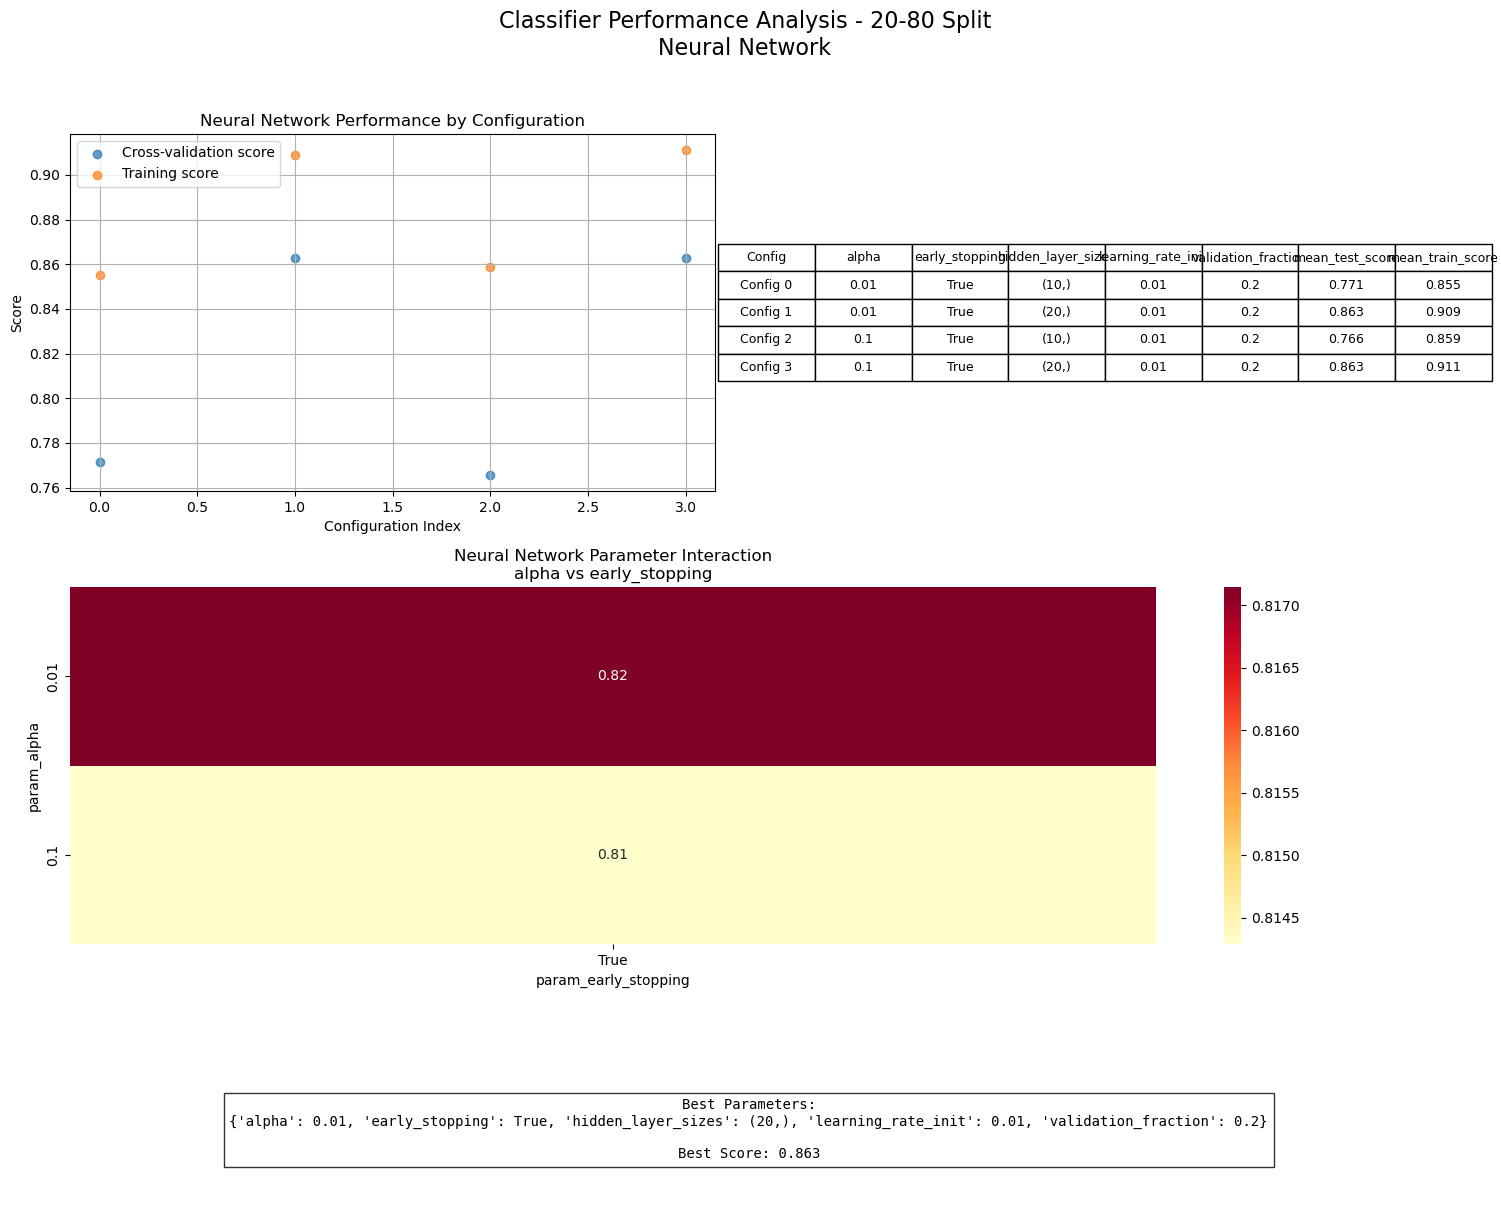

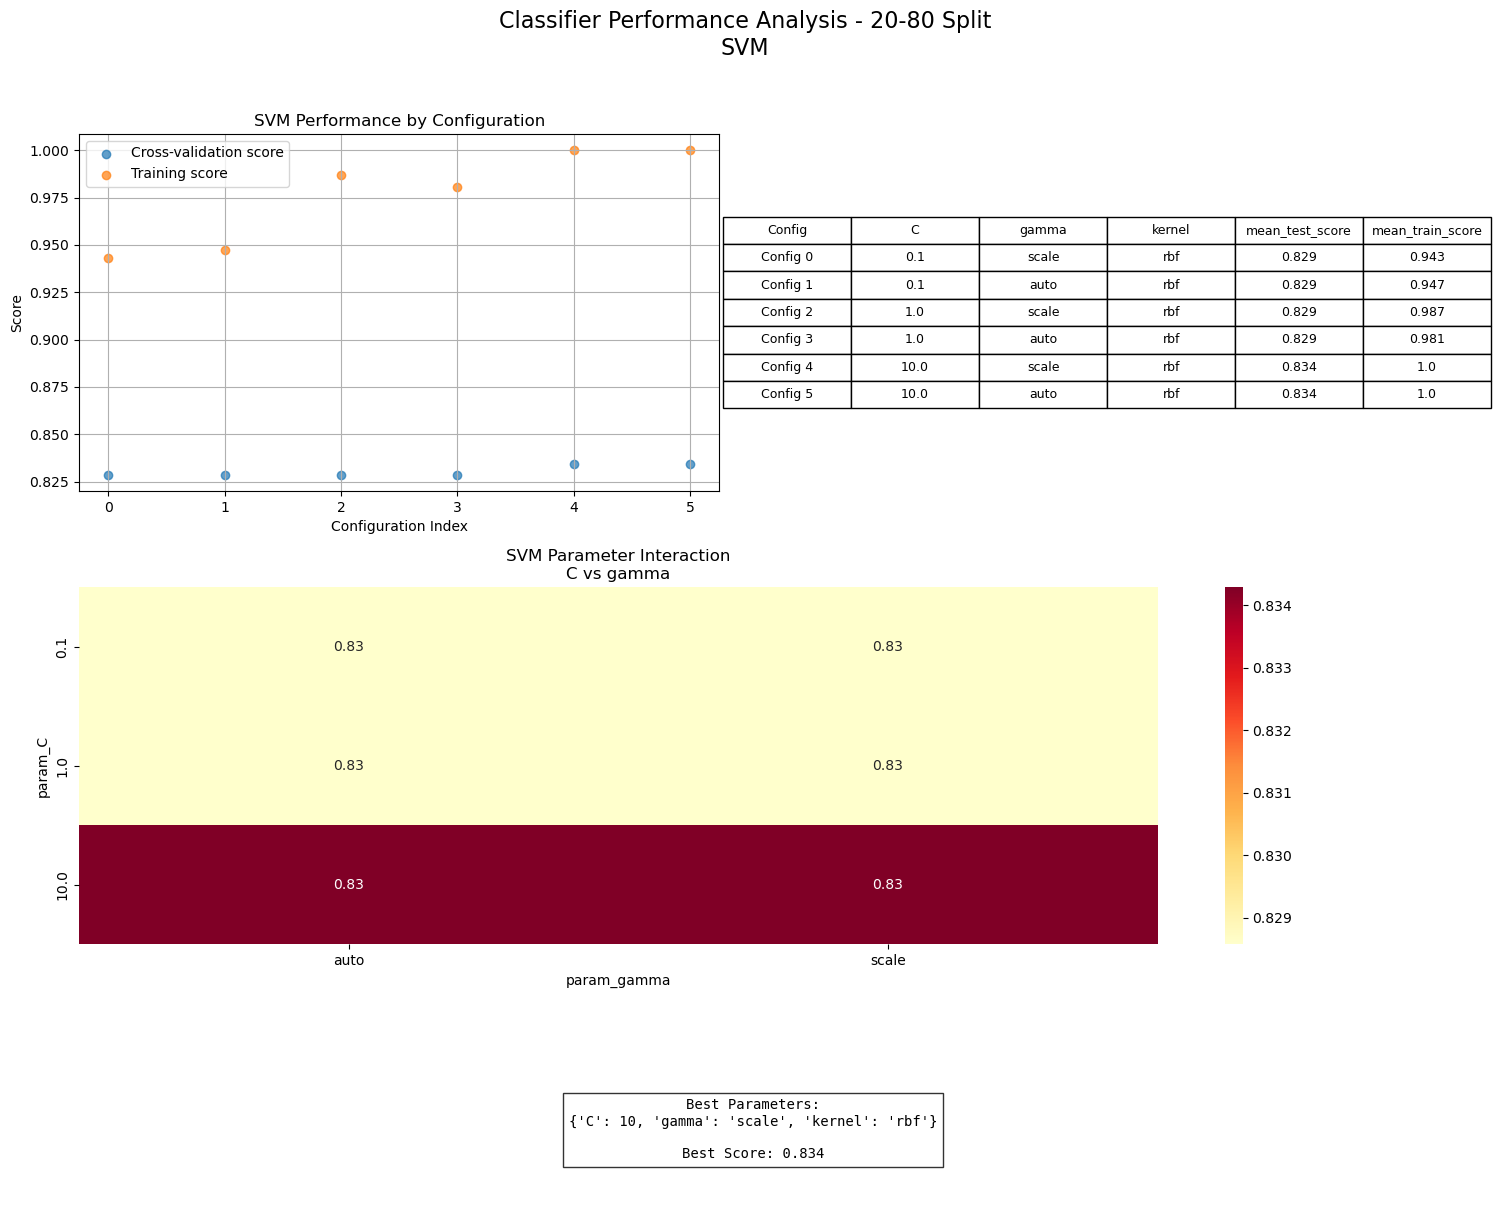


Processing split: 50-50


Trial 3, Split 50-50: 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]


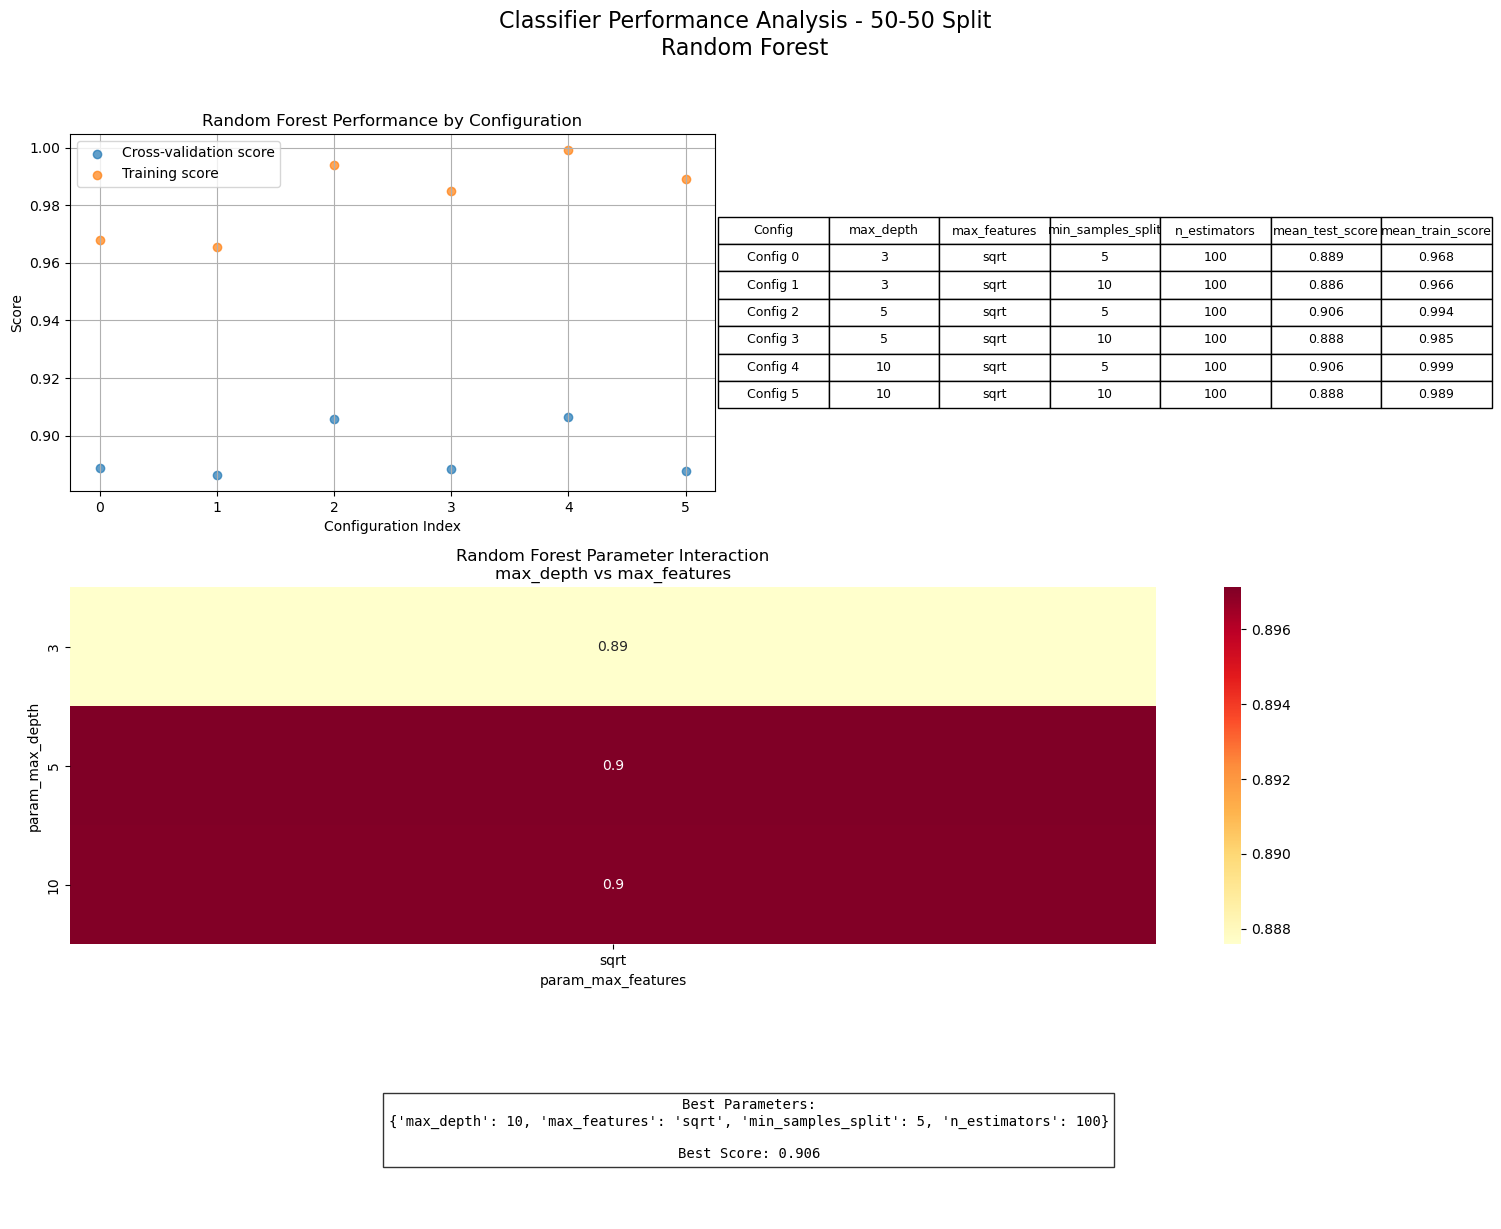

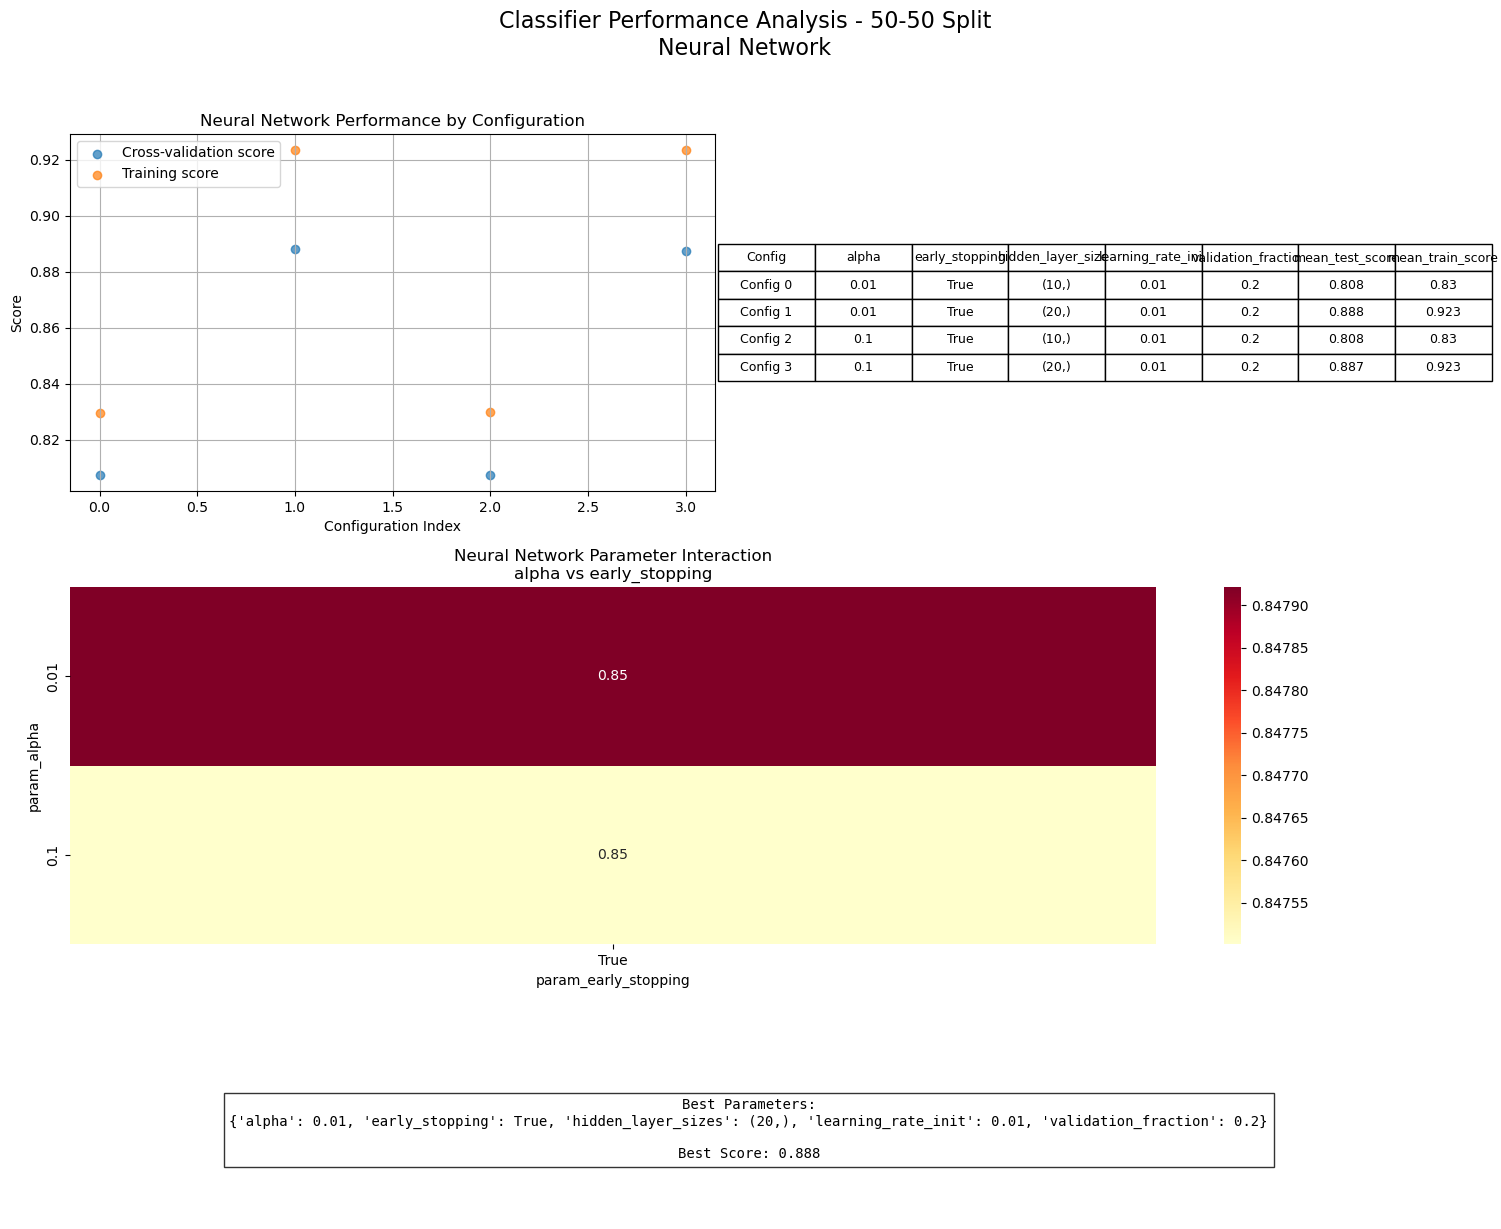

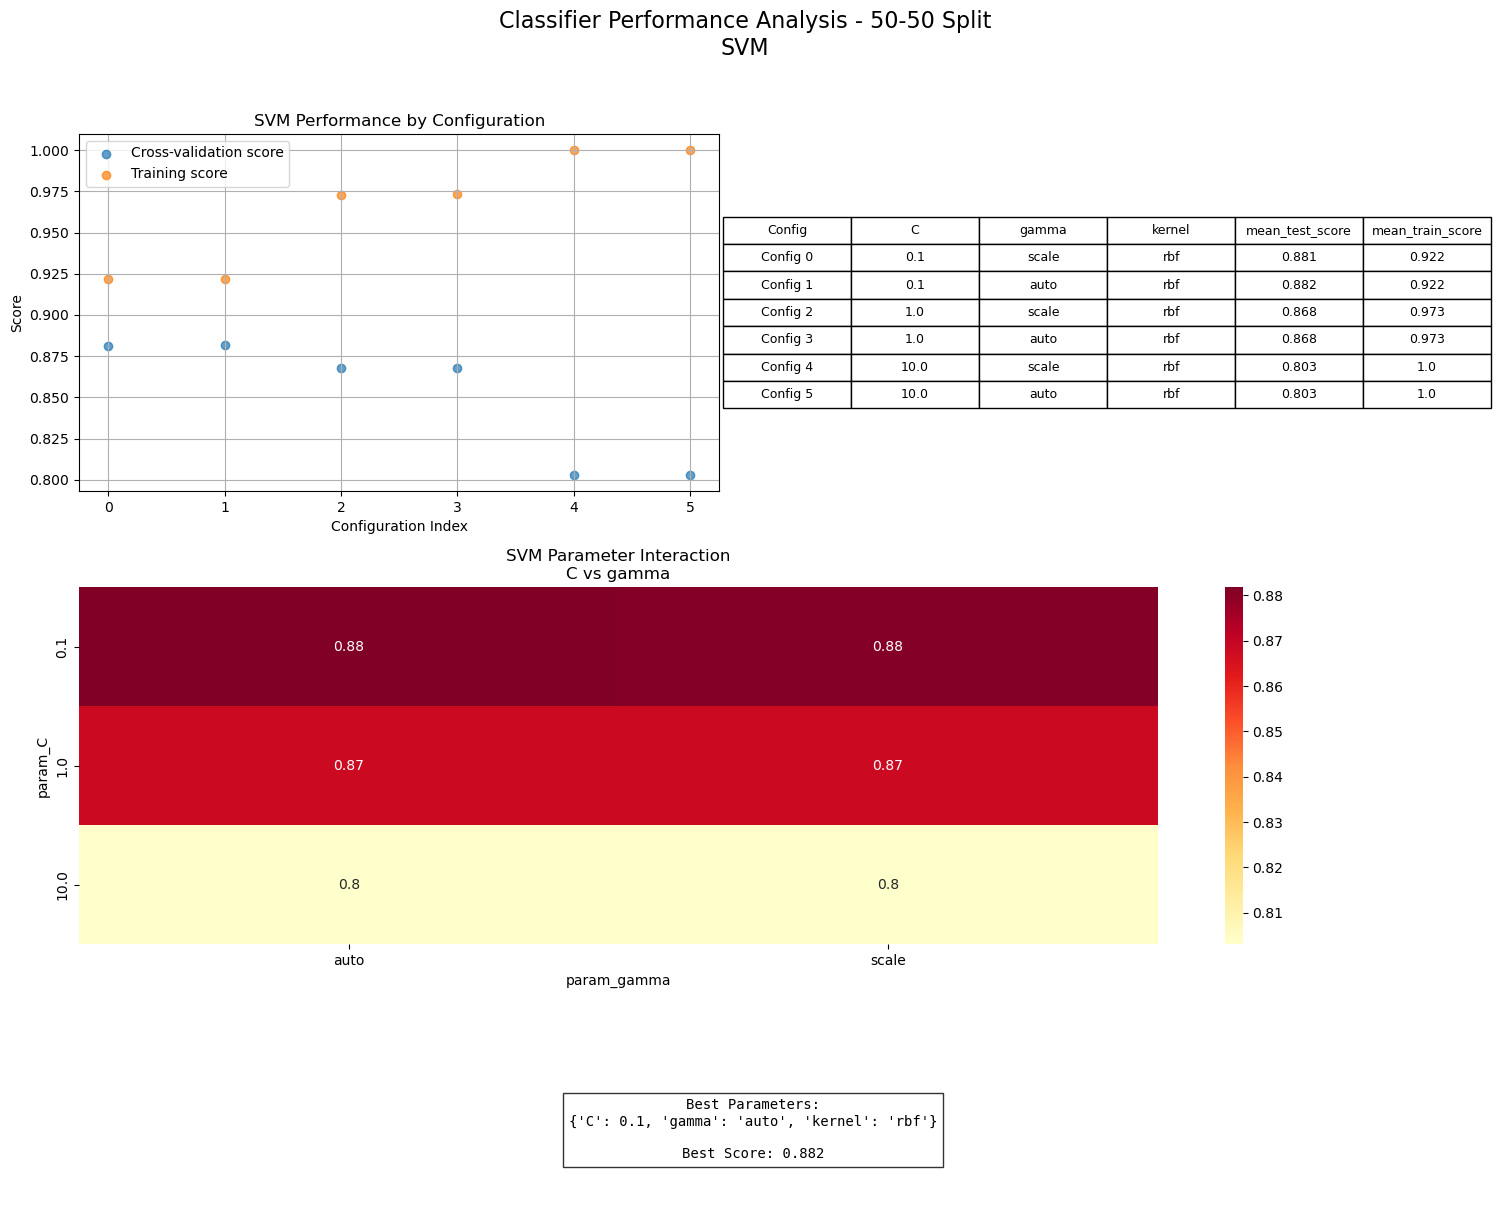


Processing split: 80-20


Trial 3, Split 80-20: 100%|██████████| 3/3 [00:09<00:00,  3.28s/it]


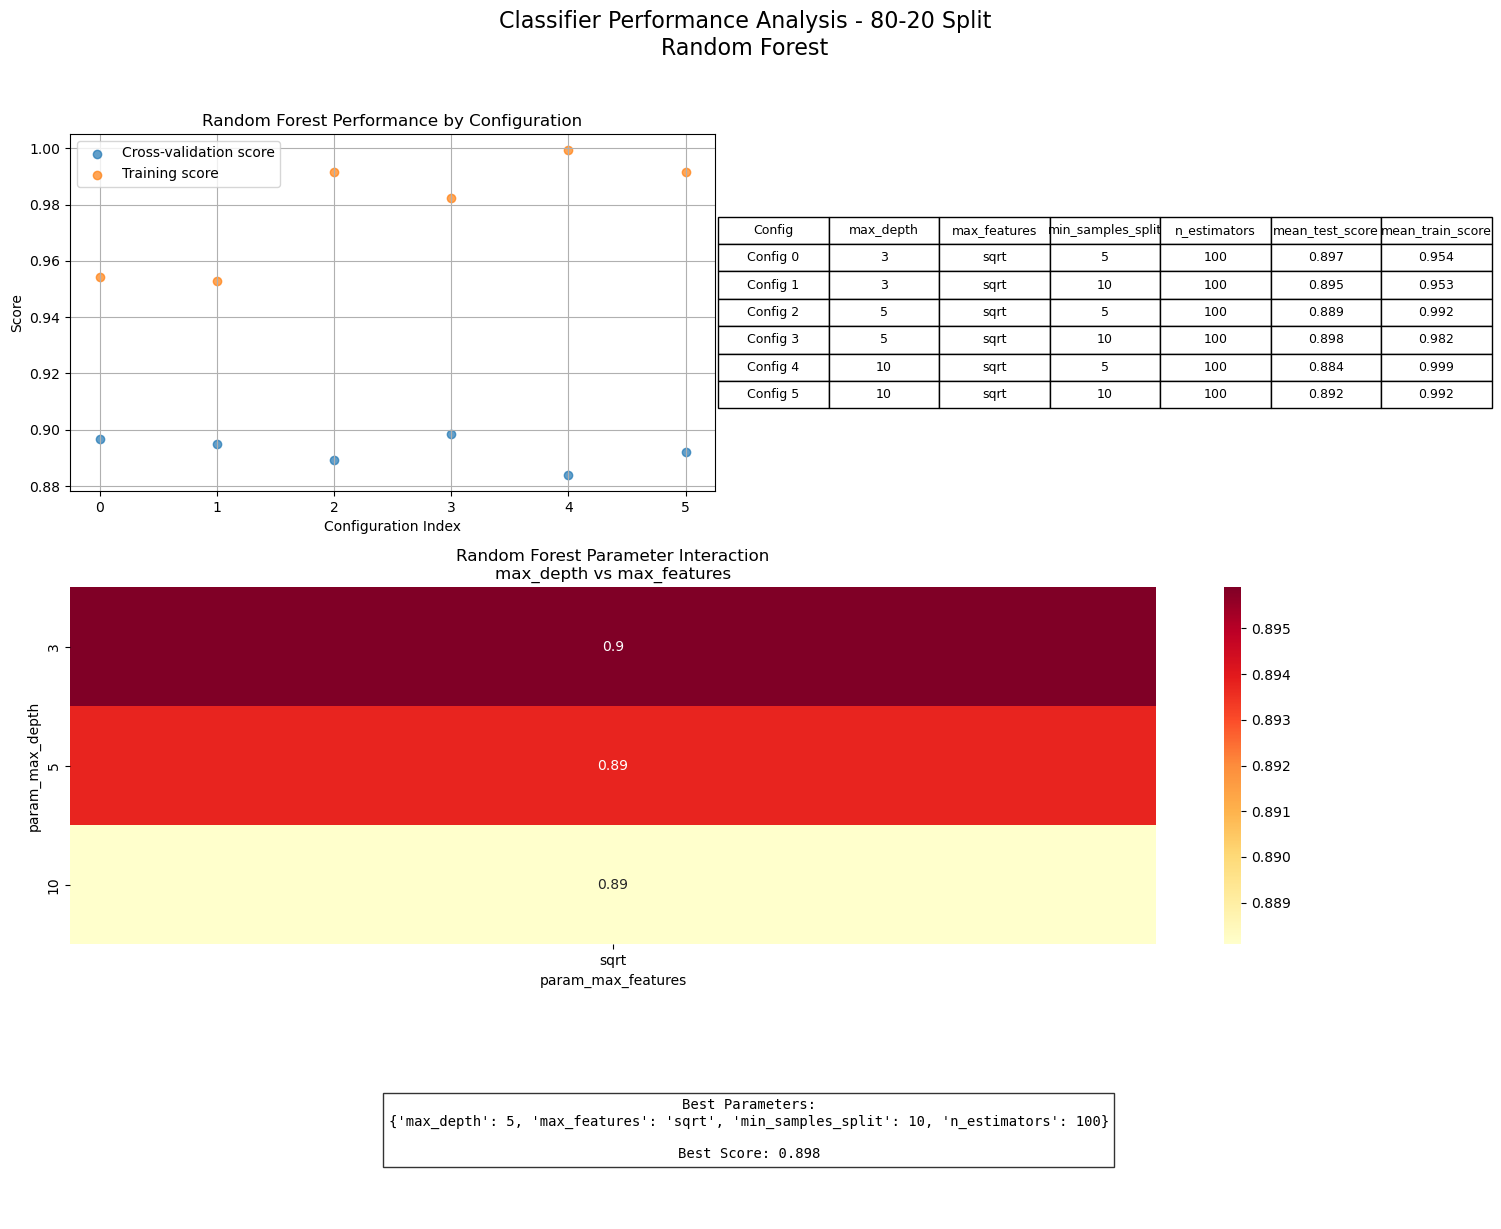

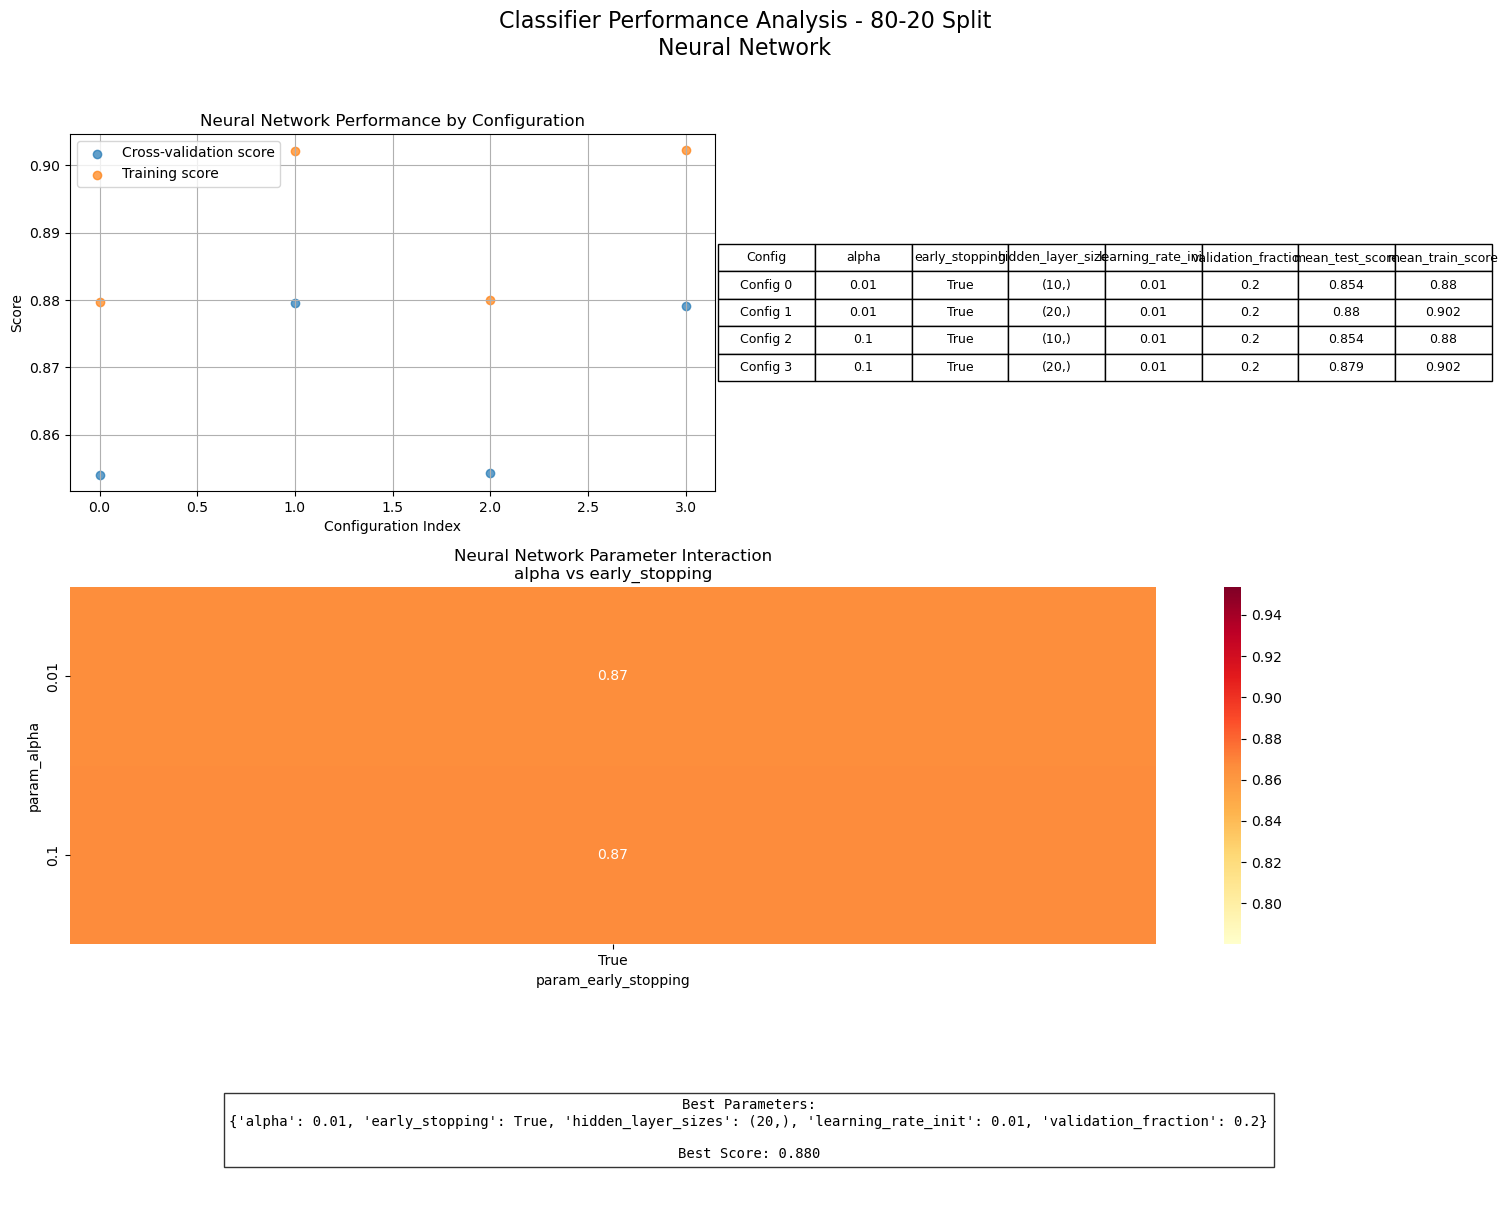

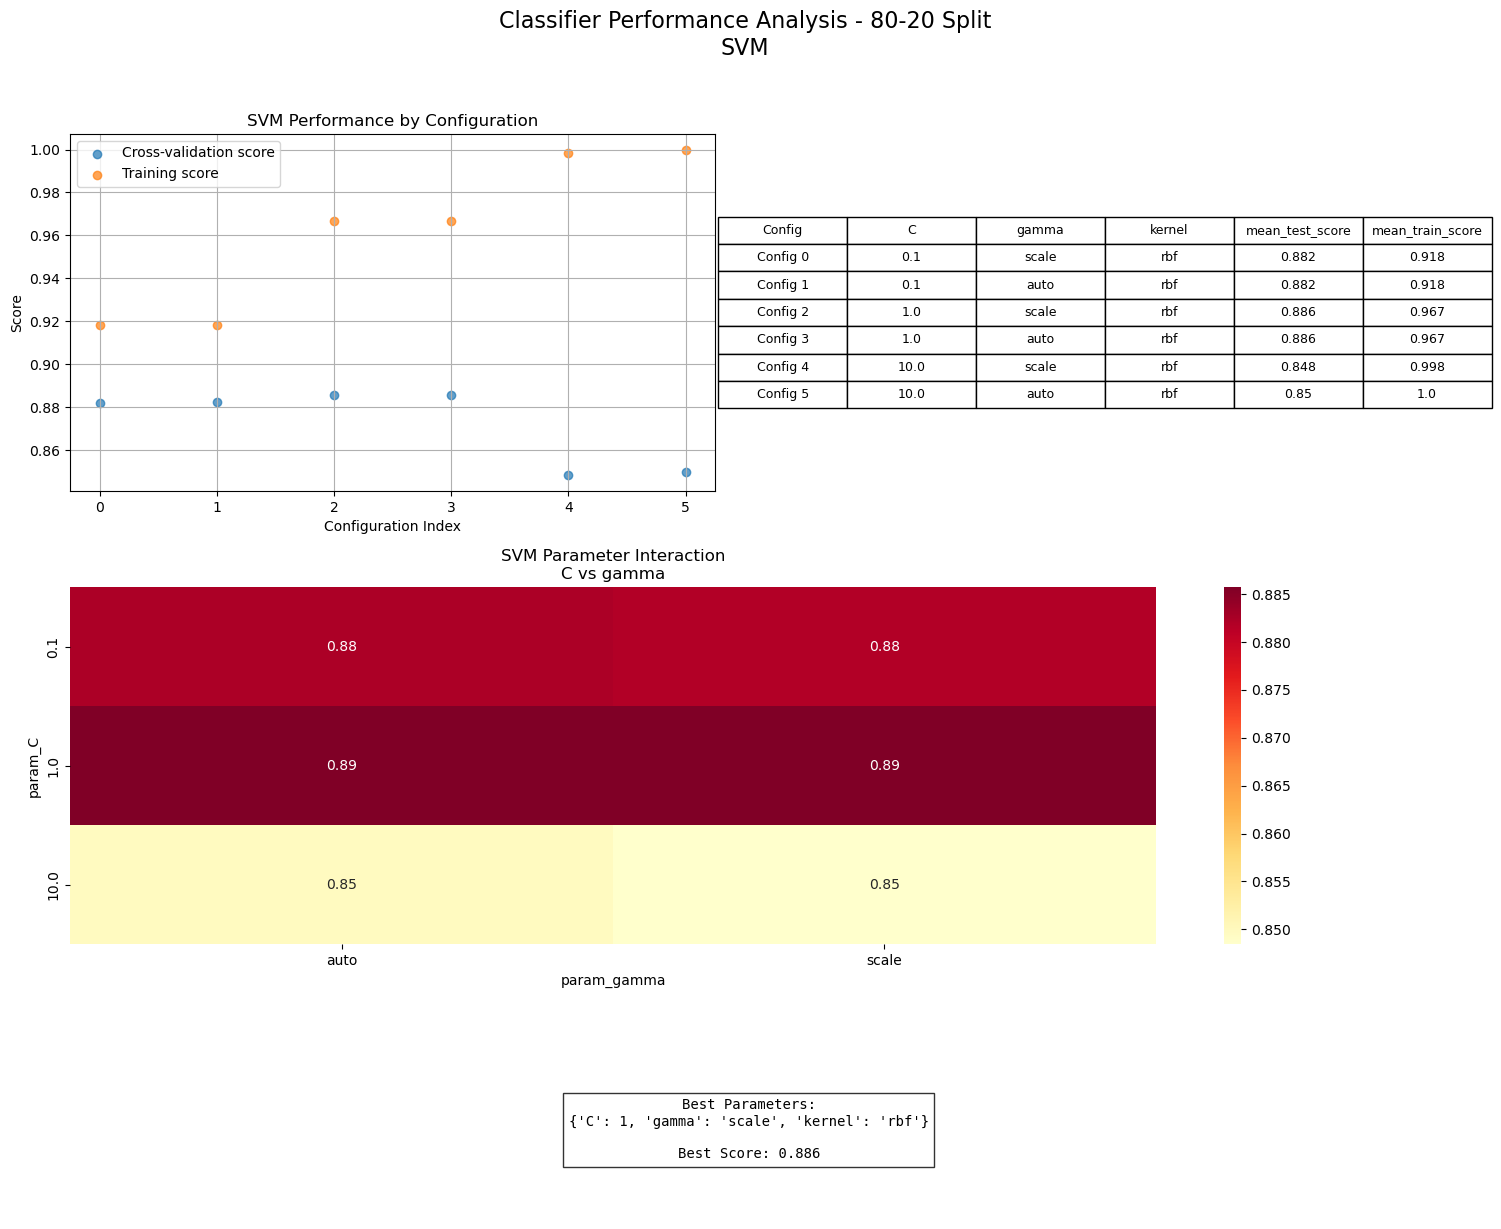


Average Performance:
                      accuracy   roc_auc
split classifier                        
20-80 Neural Network  0.699588  0.837345
      Random Forest   0.781893  0.896913
      SVM             0.720165  0.814701
50-50 Neural Network  0.815789  0.900868
      Random Forest   0.822368  0.903819
      SVM             0.809211  0.923090
80-20 Neural Network  0.819672  0.917026
      Random Forest   0.852459  0.949353
      SVM             0.901639  0.941810


In [15]:
print("Running experiments with cross-validation...")
all_results = []
for trial in range(3):
    trial_results = run_experiment_with_cv(X, y, trial)
    all_results.append(trial_results)

# Combine and analyze results
final_results = pd.concat(all_results, ignore_index=True)
avg_performance = final_results.groupby(['split', 'classifier'])[['accuracy', 'roc_auc']].mean()

# Print results
print("\nAverage Performance:")
print(avg_performance)

In [16]:
# Print best parameters for each classifier
print("\nBest Parameters:")
for clf in final_results['classifier'].unique():
    print(f"\n{clf}:")
    params = final_results[final_results['classifier'] == clf]['best_params'].iloc[0]
    print(params)


Best Parameters:

Random Forest:
{'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}

Neural Network:
{'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (20,), 'learning_rate_init': 0.01, 'validation_fraction': 0.2}

SVM:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


<Figure size 1200x600 with 0 Axes>

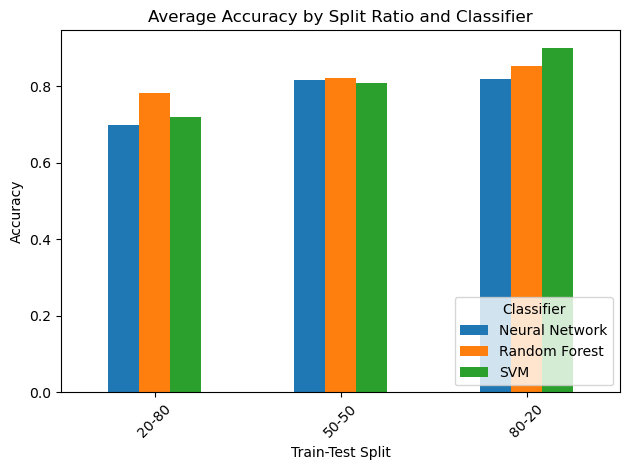

<Figure size 1200x600 with 0 Axes>

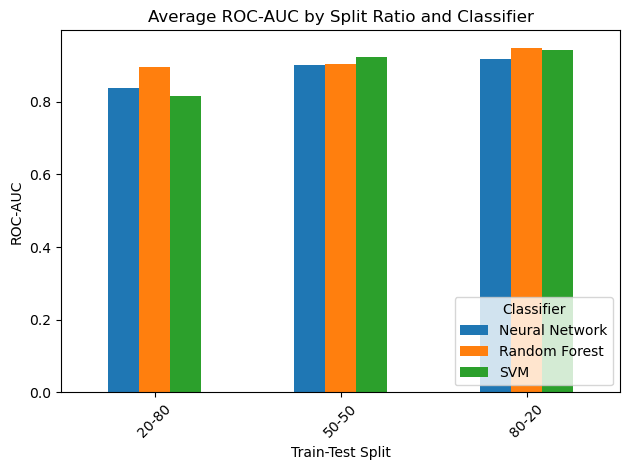

In [17]:
plt.figure(figsize=(12, 6))
avg_performance['accuracy'].unstack().plot(kind='bar')
plt.title('Average Accuracy by Split Ratio and Classifier')
plt.xlabel('Train-Test Split')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Classifier', loc='lower right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
avg_performance['roc_auc'].unstack().plot(kind='bar')
plt.title('Average ROC-AUC by Split Ratio and Classifier')
plt.xlabel('Train-Test Split')
plt.ylabel('ROC-AUC')
plt.xticks(rotation=45)
plt.legend(title='Classifier', loc='lower right')
plt.tight_layout()
plt.show()